Markdown用法

<mark><font color=red size=4 face=雅黑>叠加字体的变化<font><mark>

<mark>黄色高亮<mark>

<font color=steel size=5 face=雅黑>5号雅黑</font>

***<font color=green>绿色+加粗+斜体</font>**

## 一、读取数据

In [10]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import time
from datetime import datetime
# 导入plotly的graph_objects模块，这是用于创建交互式图表的库
# go是graph_objects的缩写，提供了各种图表类型如折线图、柱状图、散点图等
# 这个库可以创建高度交互式的可视化图表，支持缩放、悬停信息显示等功能
import plotly.graph_objects as go
import os

# 设置全局中文字体
# plt.rcParams['font.sans-serif'] = ['PingFang SC', 'SimHei', 'Microsoft YaHei', 'SimSun', 'Arial Unicode MS']
# plt.rcParams['axes.unicode_minus'] = False # 解决负号显示问题
# # 确保matplotlib能找到中文字体
# import matplotlib.font_manager as fm
# 打印可用字体列表，帮助调试
# print([f.name for f in fm.fontManager.ttflist])
#from pylab import mpl
# 设置显示中文字体
#mpl.rcParams["font.sans-serif"] = ["SimHei"]
# 设置正常显示符号


In [3]:
from WindPy import w
w.start()

Welcome to use Wind Quant API for Python (WindPy)!

COPYRIGHT (C) 2024 WIND INFORMATION CO., LTD. ALL RIGHTS RESERVED.
IN NO CIRCUMSTANCE SHALL WIND BE RESPONSIBLE FOR ANY DAMAGES OR LOSSES CAUSED BY USING WIND QUANT API FOR Python.


.ErrorCode=0
.Data=[OK!]

In [4]:
def get_stock_data(code, start_date, end_date):
    """
    从Wind获取股票数据
    
    参数:
    code: 股票代码
    start_date: 开始日期，格式'YYYY-MM-DD'
    end_date: 结束日期，格式'YYYY-MM-DD'
    
    返回:
    DataFrame: 包含股票数据的DataFrame
    """
    wind_data = w.wsd(code, "close,open,high,low,volume,pct_chg", start_date, end_date, "PriceAdj=F")
    
    if wind_data.ErrorCode != 0:
        print(f"获取数据出错: {wind_data.Data}")
        return None
        
    # 转换为DataFrame
    df = pd.DataFrame(data=wind_data.Data, 
                     index=wind_data.Fields, 
                     columns=wind_data.Times).T
    
    # 重命名列以匹配yfinance格式
    df.columns = ['Close', 'Open', 'High', 'Low', 'Volume', 'Change']
    df.index.name = 'Date'
    
    print(f"成功获取{code}的数据，共{len(df)}条记录")
    return df


data_raw = get_stock_data("000001.SH", "1995-01-01", "2025-02-28")

data = data_raw.copy()
data

成功获取000001.SH的数据，共7320条记录


,Close,Open,High,Low,Volume,Change
Date,,,,,,
1995-01-03,639.8800,637.7200,647.7100,630.5300,2.345180e+07,-1.233272
1995-01-04,653.8100,641.9000,655.5100,638.8600,4.222200e+07,2.176971
1995-01-05,646.8900,656.2000,657.4500,645.8100,4.301230e+07,-1.058411
1995-01-06,640.7600,642.7500,643.8900,636.3300,4.874820e+07,-0.947611
1995-01-09,625.9700,637.5200,637.5500,625.0400,5.098510e+07,-2.308197
...,...,...,...,...,...,...
2025-02-24,3373.0276,3374.0813,3384.8106,3355.8694,5.981882e+10,-0.180083
2025-02-25,3346.0398,3345.6534,3369.5583,3337.8448,5.275786e+10,-0.800106
2025-02-26,3380.2144,3351.2093,3380.2144,3351.2093,5.539920e+10,1.021345


In [5]:
# 将数据保存到Excel文件
# data.to_excel('000001.xlsx')
# print(f"数据已保存至: 000001.xlsx")



## 二、识别拐点

<font color=steel size=5 face=雅黑>1.Rolling Window 算法</font>

In [5]:
# 检测局部顶部的函数
# data: 价格数据数组
# curr_index: 当前检查的索引位置
# order: 窗口大小的一半（窗口总大小 = 2*order + 1）
def rw_top(data: np.array, curr_index: int, order: int) -> bool:
    # 如果当前索引小于窗口大小，无法形成完整窗口，返回False
    if curr_index < order * 2 + 1:  # 加1是因为窗口总大小为2*order+1,中心点需要前后各order个点,总共需要2*order+1个点
        return False

    top = True  # 假设是顶部
    # k 的取值范围是：[order+1, len(data)-order]
    # 原因：k作为中心点需要保证其前后各有order个点用于比较。
    k = curr_index - order  # 计算中心点索引 
    v = data[k]  # 中心点的价格值
    
    # 检查中心点前后各order个点的价格
    # 如果有任何一个点的价格高于中心点，则不是顶部
    #range(1, order + 1) 的取值范围是从 1 到 order（包含 order）的整数序列。例如，如果 order = 3，则取值为 1, 2, 3。
    
    # 从0开始遍历会导致k+i和k-i的索引超出范围
    # 因为k是中心点,需要前后各order个点进行比较
    # 所以i必须从1开始,这样k±i才能正确访问窗口内的点
    for i in range(1, order + 1):
        if data[k + i] > v or data[k - i] > v:
            top = False
            break
    
    return top

# 检测局部底部的函数
# data: 价格数据数组
# curr_index: 当前检查的索引位置
# order: 窗口大小的一半（窗口总大小 = 2*order + 1）
def rw_bottom(data: np.array, curr_index: int, order: int) -> bool:
    # 如果当前索引小于窗口大小，无法形成完整窗口，返回False
    if curr_index < order * 2 + 1:
        return False

    bottom = True  # 假设是底部
    k = curr_index - order  # 计算中心点索引
    v = data[k]  # 中心点的价格值
    
    # 检查中心点前后各order个点的价格
    # 如果有任何一个点的价格低于中心点，则不是底部
    for i in range(1, order + 1):
        if data[k + i] < v or data[k - i] < v:
            bottom = False
            break
    
    return bottom

# 找出所有极值点的函数
# data: 价格数据数组
# order: 窗口大小的一半
def rw_extremes(data: np.array, order:int):
    # 初始化存储顶部和底部的列表
    tops = []
    bottoms = []
    
    # 遍历整个数据集，i的取值范围是从0到data数组长度减1。根据上下文可以看到，data是一个包含7320行的价格数据数组，所以i的取值范围是0到7319。
    # range(len(data))会根据这个长度生成一个从0开始到len(data)-1的整数序列

    for i in range(len(data)):
        # 检查是否是顶部
        if rw_top(data, i, order):
            # 记录顶部信息：
            # top[0] = 确认索引（当前索引i）
            # top[1] = 顶部索引（i - order，即窗口中心）
            # top[2] = 顶部价格
            # 创建一个包含顶部信息的列表:
            # i: 当前确认索引位置
            # i - order: 顶部实际位置(窗口中心)
            # data[i - order]: 顶部价格值
            top = [i, i - order, data[i - order]]
            tops.append(top)  # 将找到的顶部点信息添加到tops列表中
        
        # 检查是否是底部
        if rw_bottom(data, i, order):
            # 记录底部信息：
            # bottom[0] = 确认索引（当前索引i）
            # bottom[1] = 底部索引（i - order，即窗口中心）
            # bottom[2] = 底部价格
            bottom = [i, i - order, data[i - order]]
            bottoms.append(bottom)
    
    return tops, bottoms


# 主程序入口
if __name__ == "__main__":
    # 设置窗口大小参数order=10，这意味着每个窗口包含21个点（中心点前后各10个点）
    order = 10
    # 调用rw_extremes函数检测极值点
    tops, bottoms = rw_extremes(data['Close'].to_numpy(), order)
    
    # 打印检测到的顶部信息
    print(f"检测到 {len(tops)} 个顶部:")
    for i, top in enumerate(tops[:5]):  # 只打印前5个顶部
        conf_date = data.index[top[0]]  # 确认日期
        top_date = data.index[top[1]]   # 顶部日期
        print(f"顶部 {i+1}: 确认日期={conf_date}, 顶部日期={top_date}, 价格={top[2]}")
    
    # 打印检测到的底部信息
    print(f"\n检测到 {len(bottoms)} 个底部:")
    for i, bottom in enumerate(bottoms[:5]):  # 只打印前5个底部
        conf_date = data.index[bottom[0]]  # 确认日期
        bottom_date = data.index[bottom[1]]  # 底部日期
        print(f"底部 {i+1}: 确认日期={conf_date}, 底部日期={bottom_date}, 价格={bottom[2]}")



    # 创建一个DataFrame来存储顶部和底部点的信息
    tops_df = pd.DataFrame(tops, columns=['确认索引', '顶部索引', '价格'])
    bottoms_df = pd.DataFrame(bottoms, columns=['确认索引', '底部索引', '价格'])
    
    # 添加日期信息
    tops_df['确认日期'] = tops_df['确认索引'].apply(lambda x: data.index[x])
    tops_df['顶部日期'] = tops_df['顶部索引'].apply(lambda x: data.index[x])
    bottoms_df['确认日期'] = bottoms_df['确认索引'].apply(lambda x: data.index[x])
    bottoms_df['底部日期'] = bottoms_df['底部索引'].apply(lambda x: data.index[x])
    
    # 重新排列列顺序
    tops_df = tops_df[['确认日期', '顶部日期', '价格', '确认索引', '顶部索引']]
    bottoms_df = bottoms_df[['确认日期', '底部日期', '价格', '确认索引', '底部索引']]
    
    # # 创建Excel写入器
    # with pd.ExcelWriter('【Rolling Window】极值点数据.xlsx') as writer:
    #     tops_df.to_excel(writer, sheet_name='顶部点', index=False)
    #     bottoms_df.to_excel(writer, sheet_name='底部点', index=False)
    
    # print("极值点数据已保存到'【Rolling Window】极值点数据.xlsx'文件中")


    # 创建图表
    # 使用plotly创建图表
    fig = go.Figure()
    
    # 添加收盘价线图
    fig.add_trace(go.Scatter(
        x=data.index,  # data.index包含了DataFrame的索引,在这里是日期数据,用作x轴的时间坐标
        y=data['Close'],  # data['Close']是DataFrame的'Close'列,包含了股票的收盘价数据,用作y轴的数值坐标
        mode='lines',  # 设置绘图模式为'lines'表示用线条连接各个数据点
        name='收盘价',  # 设置图例名称为'收盘价'
        line=dict(width=2)  # 设置线条宽度为2个像素
    ))
    
    # 创建顶部和底部点的字典
    # 转折点字典 (Turning Points Dictionary)
    Turning_points = {
        "顶部": [[top[1], top[2], top[0]] for top in tops],
        "底部": [[bottom[1], bottom[2], bottom[0]] for bottom in bottoms]
    }
    
    # 转折点
    for Turning_type, points in Turning_points.items():
        points_x, points_y, _ = zip(*points)
        points_x = [data.index[x] for x in points_x]  # 直接使用datetime索引,不进行格式化
        # 使用字典直接映射转折点类型到对应颜色
        colors = {
            "顶部": "rgba(192,0,0,0.5)",  # 红色，透明度0.5
            "底部": "rgba(78,167,46,0.5)"   # 绿色，透明度0.5
        }
        color = colors[Turning_type]
        fig.add_trace(go.Scatter(x=points_x, 
                                y=points_y,
                                mode='markers',
                                name=Turning_type,
                                marker=dict(
                                    color=color,
                                    size=7,
                                    line=dict(width=1)
                                )))
    
    # 设置图表布局
    fig.update_layout(
        title={
            'text': f"上证指数价格与Rolling Window检测的极值点 (order={order})",
            'x': 0.5,  # 标题居中
            'xanchor': 'center'
        },
        xaxis_title="日期",
        yaxis_title="收盘价",
        # 这是设置图表的样式模板为"plotly_white"，它是Plotly库中预定义的一种白色主题样式。Plotly还提供了其他样式如"plotly_dark"(深色主题)、"plotly"(默认样式)、"seaborn"(类似Seaborn库风格)、"ggplot2"(类似R的ggplot2风格)、"simple_white"(简洁白色)等多种模板
        template="plotly",  
        width=1200,
        height=600,
        xaxis_rangeslider_visible = True
    
    )
    

    fig.show()
    


检测到 197 个顶部:
顶部 1: 确认日期=1995-03-21, 顶部日期=1995-03-07, 价格=632.96
顶部 2: 确认日期=1995-04-21, 顶部日期=1995-04-07, 价格=673.72
顶部 3: 确认日期=1995-06-05, 顶部日期=1995-05-22, 价格=897.42
顶部 4: 确认日期=1995-08-01, 顶部日期=1995-07-18, 价格=715.47
顶部 5: 确认日期=1995-08-28, 顶部日期=1995-08-14, 价格=776.13

检测到 216 个底部:
底部 1: 确认日期=1995-02-21, 底部日期=1995-02-07, 价格=532.49
底部 2: 确认日期=1995-05-24, 底部日期=1995-05-10, 价格=565.14
底部 3: 确认日期=1995-07-17, 底部日期=1995-07-03, 价格=613.18
底部 4: 确认日期=1995-09-13, 底部日期=1995-08-30, 价格=715.73
底部 5: 确认日期=1995-10-30, 底部日期=1995-10-16, 价格=701.34


<font color=steel size=5 face=雅黑>2.Directional Change 算法</font>

In [6]:
def directional_change(close: np.array, high: np.array, low: np.array, sigma: float):
    """
    方向性变化算法 - 根据价格回撤幅度检测市场转折点
    
    参数:
    close: 收盘价数组
    high: 最高价数组
    low: 最低价数组
    sigma: 回撤阈值，例如0.02表示2%的回撤
    
    返回:
    tops: 检测到的顶部列表，每个顶部包含[确认索引, 顶部索引, 顶部价格]
    bottoms: 检测到的底部列表，每个底部包含[确认索引, 底部索引, 底部价格]
    """
    
    # 初始状态：假设最后一个极值是底部，下一个将是顶部
    up_zig = True 
    
    # 初始化临时变量，用于跟踪当前的最高点和最低点
    tmp_max = high[0]  # 当前最高价
    tmp_min = low[0]   # 当前最低价
    tmp_max_i = 0      # 当前最高价的索引
    tmp_min_i = 0      # 当前最低价的索引

    # 存储检测到的顶部和底部
    tops = []
    bottoms = []

    # 遍历价格数据
    for i in range(len(close)):
        if up_zig:  # 如果最后一个极值是底部，我们正在寻找顶部
            if high[i] > tmp_max:
                # 发现新的最高价，更新临时最高点
                tmp_max = high[i]
                tmp_max_i = i
            elif close[i] < tmp_max - tmp_max * sigma: 
                # 价格从最高点回落超过sigma%，确认一个顶部
                # top[0] = 确认索引（当前索引i）
                # top[1] = 顶部索引（tmp_max_i）
                # top[2] = 顶部价格（tmp_max）
                top = [i, tmp_max_i, tmp_max]
                tops.append(top)

                # 设置寻找下一个底部的初始状态
                up_zig = False  # 切换状态，现在寻找底部
                tmp_min = low[i]  # 初始化当前最低价
                tmp_min_i = i     # 初始化当前最低价的索引
        else:  # 如果最后一个极值是顶部，我们正在寻找底部
            if low[i] < tmp_min:
                # 发现新的最低价，更新临时最低点
                tmp_min = low[i]
                tmp_min_i = i
            elif close[i] > tmp_min + tmp_min * sigma: 
                # 价格从最低点上涨超过sigma%，确认一个底部
                # bottom[0] = 确认索引（当前索引i）
                # bottom[1] = 底部索引（tmp_min_i）
                # bottom[2] = 底部价格（tmp_min）
                bottom = [i, tmp_min_i, tmp_min]
                bottoms.append(bottom)

                # 设置寻找下一个顶部的初始状态
                up_zig = True  # 切换状态，现在寻找顶部
                tmp_max = high[i]  # 初始化当前最高价
                tmp_max_i = i      # 初始化当前最高价的索引

    return tops, bottoms

def get_extremes(ohlc: pd.DataFrame, sigma: float):
    """
    将directional_change函数的结果转换为DataFrame格式
    
    参数:
    ohlc: 包含'close', 'high', 'low'列的DataFrame
    sigma: 回撤阈值
    
    返回:
    extremes: 包含所有极值点的DataFrame，按确认索引排序
    """
    # 调用directional_change函数获取顶部和底部
    tops, bottoms = directional_change(ohlc['close'], ohlc['high'], ohlc['low'], sigma)
    
    # 将顶部和底部转换为DataFrame
    tops = pd.DataFrame(tops, columns=['conf_i', 'ext_i', 'ext_p'])
    bottoms = pd.DataFrame(bottoms, columns=['conf_i', 'ext_i', 'ext_p'])
    
    # 添加类型标识：1表示顶部，-1表示底部
    tops['type'] = 1
    bottoms['type'] = -1
    
    # 合并顶部和底部
    extremes = pd.concat([tops, bottoms])
    
    # 按确认索引排序
    extremes = extremes.set_index('conf_i')
    extremes = extremes.sort_index()
    
    return extremes


# 主程序入口
if __name__ == "__main__":
    
    sigma = 0.05
    # 调用directional_change函数检测极值点
    tops, bottoms = directional_change(data['Close'].to_numpy(), data['High'].to_numpy(), data['Low'].to_numpy(), sigma)
    
    # 打印检测到的顶部信息
    print(f"检测到 {len(tops)} 个顶部:")
    for i, top in enumerate(tops[:5]):  # 只打印前5个顶部
        conf_date = data.index[top[0]]  # 确认日期
        top_date = data.index[top[1]]   # 顶部日期
        conf_price = data['Close'][top[0]]  # 确认日期价格
        top_price = top[2]  # 顶部价格
        amplitude = (top_price - conf_price) / conf_price * 100  # 振幅
        print(f"顶部 {i+1}: 确认日期={conf_date}, 确认价格={conf_price:.2f}, 顶部日期={top_date}, 顶部价格={top_price:.2f}, 振幅={amplitude:.2f}%")
    
    # 打印检测到的底部信息
    print(f"\n检测到 {len(bottoms)} 个底部:")
    for i, bottom in enumerate(bottoms[:5]):  # 只打印前5个底部
        conf_date = data.index[bottom[0]]  # 确认日期
        bottom_date = data.index[bottom[1]]  # 底部日期
        conf_price = data['Close'][bottom[0]]  # 确认日期价格
        bottom_price = bottom[2]  # 底部价格
        amplitude = (conf_price - bottom_price) / bottom_price * 100  # 振幅
        print(f"底部 {i+1}: 确认日期={conf_date}, 确认价格={conf_price:.2f}, 底部日期={bottom_date}, 底部价格={bottom_price:.2f}, 振幅={amplitude:.2f}%")

    # 创建一个DataFrame来存储顶部和底部点的信息
    tops_df = pd.DataFrame(tops, columns=['确认索引', '顶部索引', '顶部价格'])
    bottoms_df = pd.DataFrame(bottoms, columns=['确认索引', '底部索引', '底部价格'])
    
    # 添加日期和价格信息
    # 这行代码的作用是:
    # 1. tops_df['确认日期'] 创建一个新列叫"确认日期"
    # 2. apply()方法对"确认索引"列的每个值x执行lambda函数
    # 3. lambda x: data.index[x] 是一个匿名函数,用x作为索引从data.index中获取对应的日期
    # 4. 最终将每个确认索引对应的日期填入"确认日期"列
    tops_df['确认日期'] = tops_df['确认索引'].apply(lambda x: data.index[x])
    tops_df['确认价格'] = tops_df['确认索引'].apply(lambda x: data['Close'][x])
    tops_df['顶部日期'] = tops_df['顶部索引'].apply(lambda x: data.index[x])
    tops_df['振幅'] = (tops_df['顶部价格'] - tops_df['确认价格']) / tops_df['确认价格'] * 100
    
    bottoms_df['确认日期'] = bottoms_df['确认索引'].apply(lambda x: data.index[x])
    bottoms_df['确认价格'] = bottoms_df['确认索引'].apply(lambda x: data['Close'][x])
    bottoms_df['底部日期'] = bottoms_df['底部索引'].apply(lambda x: data.index[x])
    bottoms_df['振幅'] = (bottoms_df['确认价格'] - bottoms_df['底部价格']) / bottoms_df['底部价格'] * 100
    
    # 重新排列列顺序
    tops_df = tops_df[['确认日期', '确认价格', '顶部日期', '顶部价格', '振幅', '确认索引', '顶部索引']]
    bottoms_df = bottoms_df[['确认日期', '确认价格', '底部日期', '底部价格', '振幅', '确认索引', '底部索引']]
    
    # 创建Excel写入器
    with pd.ExcelWriter('【Directional Change】极值点数据.xlsx') as writer:
        tops_df.to_excel(writer, sheet_name='顶部点', index=False)
        bottoms_df.to_excel(writer, sheet_name='底部点', index=False)
    
    print("极值点数据已保存到'【Directional Change】极值点数据.xlsx'文件中")

    # 创建图表对象
    # go.Figure()是plotly库中的一个函数,用于创建一个空的图形对象
    # 它提供了一个画布,我们可以在上面添加各种图表元素,如线图、散点图等
    # 创建一个空的图形对象,后续可以通过add_trace方法添加图表
    fig = go.Figure()
    
    # 添加收盘价线图,显示为连续线条
    fig.add_trace(go.Scatter(
        x=data.index,  # x轴为日期索引
        y=data['Close'],  # y轴为收盘价
        mode='lines',  # 显示模式为线条
        name='收盘价',  # 图例名称
        line=dict(width=2)  # 线条宽度为2
    ))

    # 注释掉的K线图代码,如需显示K线可取消注释
    # fig.add_trace(go.Candlestick(
    #         x=data.index,  # x轴为日期索引
    #         open=data['Open'],  # 开盘价
    #         high=data['High'],  # 最高价
    #         low=data['Low'],  # 最低价
    #         close=data['Close'],  # 收盘价
    #         name='K线'  # 图例名称
    # ))
    
    # 创建顶部和底部点的字典,存储转折点信息
    Turning_points = {
        "顶部": [[top[1], top[2], top[0]] for top in tops],  # 顶部点列表:[顶部索引,顶部价格,确认索引]
        "底部": [[bottom[1], bottom[2], bottom[0]] for bottom in bottoms]  # 底部点列表:[底部索引,底部价格,确认索引]
    }
    
    # 添加转折点标记
    # Turning_points是一个字典数据结构,用于存储和组织数据
    # 使用字典的原因:
    # 1. 可以通过"顶部"和"底部"这两个键快速访问对应的转折点数据
    # 2. 结构清晰,便于分别处理顶部点和底部点
    # 3. 代码可读性好,后续遍历处理数据时逻辑简单
    # Turning_type是字典的键("顶部"或"底部"),points是对应的值(转折点列表)
    # points中每个元素是[索引,价格,确认索引]格式的列表
    # zip(*points)将points中的每个列表解压成3个元组,分别对应索引、价格和确认索引
    # 我们只需要前两个值(索引和价格)作为x,y坐标,所以用_忽略第三个值
    for Turning_type, points in Turning_points.items():
        points_x, points_y, _ = zip(*points)  # 解压获取索引和价格,忽略确认索引
        points_x = [data.index[x] for x in points_x]  # 将索引转换为实际日期
        colors = {
            "顶部": "rgba(192,0,0,0.5)",  # 顶部点为红色,透明度0.5
            "底部": "rgba(78,167,46,0.5)"  # 底部点为绿色,透明度0.5
        }
        color = colors[Turning_type]
        # 添加散点标记
        fig.add_trace(go.Scatter(x=points_x, 
                                y=points_y,
                                mode='markers',  # 显示模式为标记点
                                name=Turning_type,  # 图例名称
                                marker=dict(
                                    color=color,  # 标记点颜色
                                    size=7,  # 标记点大小
                                    line=dict(width=1)  # 标记点边框宽度
                                )))
    
    # 设置图表布局
    fig.update_layout(
        title={
            'text': f"上证指数价格与Directional Change检测的极值点 (sigma={sigma*100}%)",  # 图表标题
            'x': 0.5,  # 标题水平位置
            'xanchor': 'center'  # 标题对齐方式
        },
        xaxis_title="日期",  # x轴标题
        yaxis_title="收盘价",  # y轴标题
        template="plotly",  # 使用plotly默认模板
        width=1200,  # 图表宽度
        height=600,  # 图表高度
        xaxis_rangeslider_visible = True  # 显示时间范围选择器
    )
    
    # 显示图表
    fig.show()


检测到 198 个顶部:
顶部 1: 确认日期=1995-01-10, 确认价格=610.30, 顶部日期=1995-01-05, 顶部价格=657.45, 振幅=7.73%
顶部 2: 确认日期=1995-02-24, 确认价格=558.43, 顶部日期=1995-02-23, 顶部价格=608.58, 振幅=8.98%
顶部 3: 确认日期=1995-03-09, 确认价格=605.59, 顶部日期=1995-03-08, 顶部价格=639.01, 振幅=5.52%
顶部 4: 确认日期=1995-04-11, 确认价格=641.08, 顶部日期=1995-04-10, 顶部价格=681.15, 振幅=6.25%
顶部 5: 确认日期=1995-05-23, 确认价格=750.30, 顶部日期=1995-05-22, 顶部价格=926.41, 振幅=23.47%

检测到 198 个底部:
底部 1: 确认日期=1995-02-09, 确认价格=553.35, 底部日期=1995-02-07, 底部价格=524.42, 振幅=5.52%
底部 2: 确认日期=1995-03-03, 确认价格=577.22, 底部日期=1995-02-28, 底部价格=544.06, 振幅=6.09%
底部 3: 确认日期=1995-03-22, 确认价格=613.70, 底部日期=1995-03-15, 底部价格=568.60, 振幅=7.93%
底部 4: 确认日期=1995-04-28, 确认价格=579.93, 底部日期=1995-04-27, 底部价格=547.21, 振幅=5.98%
底部 5: 确认日期=1995-05-29, 确认价格=710.59, 底部日期=1995-05-26, 底部价格=672.37, 振幅=5.68%
极值点数据已保存到'【Directional Change】极值点数据.xlsx'文件中


<font color=steel size=5 face=雅黑>3.Perceptually Important Points 算法</font>

In [7]:
from matplotlib import pyplot as plt


def find_pips(data: np.array, n_pips: int, dist_measure: int):
    """
    感知重要点(Perceptually Important Points, PIP)算法
    
    参数:
    data: 价格数据数组
    n_pips: 要识别的重要点数量
    dist_measure: 距离度量方式
        1 = 欧几里得距离(Euclidean Distance)
        2 = 垂直距离(Perpendicular Distance)
        3 = 垂直距离(Vertical Distance)
    
    返回:
    pips_x: 重要点的索引
    pips_y: 重要点的价格值
    """
    # 初始化，将起点和终点作为第一批重要点
    # len(data)-1 是因为数组索引从0开始,最后一个元素的索引是长度减1
    pips_x = [0, len(data) - 1]  # 索引,0表示第一个点,len(data)-1表示最后一个点
    pips_y = [data[0], data[-1]]  # 价格,data[0]是第一个价格,data[-1]是最后一个价格

    # 迭代添加n_pips-2个重要点（因为已经有起点和终点两个点）
    for curr_point in range(2, n_pips):
        md = 0.0  # 最大距离
        md_i = -1  # 最大距离对应的索引,初始化为-1表示还未找到最大距离点
        insert_index = -1  # 插入位置,初始化为-1表示还未确定插入位置

        # 遍历当前已有的重要点之间的所有区间
        for k in range(0, curr_point - 1):
            # 获取左右相邻重要点的索引
            # 获取相邻两个重要点的索引,用于构建线段
            # left_adj表示左侧重要点在pips数组中的位置
            # right_adj表示右侧重要点在pips数组中的位置
            left_adj = k  
            right_adj = k + 1

            # 计算这两个重要点之间的直线方程 y = slope * x + intercept
            # 用于后续计算其他点到这条线段的距离
            time_diff = pips_x[right_adj] - pips_x[left_adj]
            price_diff = pips_y[right_adj] - pips_y[left_adj]
            slope = price_diff / time_diff  # 计算斜率
            intercept = pips_y[left_adj] - pips_x[left_adj] * slope  # 计算截距

            # 遍历两个重要点之间的所有点
            for i in range(pips_x[left_adj] + 1, pips_x[right_adj]):
                d = 0.0  # 距离
                
                # 根据选择的距离度量方式计算距离
                if dist_measure == 1:  # 欧几里得距离
                    # 计算点到左右两个重要点的欧几里得距离之和
                    d = ((pips_x[left_adj] - i) ** 2 + (pips_y[left_adj] - data[i]) ** 2) ** 0.5
                    d += ((pips_x[right_adj] - i) ** 2 + (pips_y[right_adj] - data[i]) ** 2) ** 0.5
                elif dist_measure == 2:  # 垂直距离（点到直线的垂直距离）
                    # 计算点到直线的垂直距离
                    # 这里计算的是点到直线的垂直距离
                    # 例如: 假设有一条直线 y = 2x + 1, 点P(3,8)
                    # slope = 2 (斜率)
                    # intercept = 1 (截距) 
                    # i = 3 (x坐标)
                    # data[i] = 8 (y坐标)
                    # 代入公式: |2*3 + 1 - 8| / sqrt(2^2 + 1) = |7-8| / sqrt(5) = 1/sqrt(5)
                    # 计算点到直线的垂直距离:
                    # 1. slope * i + intercept 计算直线在该点x坐标处的y值
                    # 2. data[i] 是该点实际的y值
                    # 3. 两者相减得到垂直差值
                    # 4. 除以 sqrt(slope^2 + 1) 将差值转换为垂直距离
                    # 5. abs() 取绝对值,因为我们只关心距离大小,不关心方向
                    d = abs((slope * i + intercept) - data[i]) / (slope ** 2 + 1) ** 0.5
                else:  # 垂直距离（点到直线的垂直距离，不考虑斜率）
                    # 计算点到直线的垂直距离（简化版）
                    d = abs((slope * i + intercept) - data[i])

                # 如果找到更大的距离，更新最大距离和对应的索引
                if d > md:
                    md = d
                    # 记录当前找到的最大距离点的索引i
                    md_i = i
                    # right_adj是当前区间右端点的位置,将新点插入到right_adj位置
                    insert_index = right_adj

        # 将新找到的重要点插入到重要点列表中
        pips_x.insert(insert_index, md_i)
        pips_y.insert(insert_index, data[md_i])

    return pips_x, pips_y


# 主程序入口
if __name__ == "__main__":
    # 设置参数
    n_pips = 100  # 要识别的重要点数量
    dist_measure = 2  # 使用垂直距离度量
    
    # 获取收盘价数据
    close_prices = data['Close'].to_numpy()
    
    # 调用PIP算法找出重要点
    pips_x, pips_y = find_pips(close_prices, n_pips, dist_measure)
    
    # 打印检测到的重要点信息
    print(f"检测到 {len(pips_x)} 个重要点:")
    for i, (x, y) in enumerate(zip(pips_x[:5], pips_y[:5])):  # 只打印前5个点
        point_date = data.index[x]
        print(f"重要点 {i+1}: 日期={point_date}, 价格={y:.2f}")
    
    # 创建DataFrame来存储重要点信息
    pips_df = pd.DataFrame({
        '日期': [data.index[x] for x in pips_x],
        '价格': pips_y,
        '索引': pips_x
    })
    
    # 保存到Excel
    with pd.ExcelWriter('【PIP算法】重要点数据.xlsx') as writer:
        pips_df.to_excel(writer, sheet_name='重要点', index=False)
    
    print("\n重要点数据已保存到'【PIP算法】重要点数据.xlsx'文件中")

 
    
    # 创建图表
    fig = go.Figure()
    
    # 添加收盘价线图
    fig.add_trace(go.Scatter(
        x=data.index,
        y=data['Close'],
        mode='lines',
        name='收盘价',
        line=dict(width=2)
    ))
    
    # 添加重要点标记
    fig.add_trace(go.Scatter(
        x=[data.index[x] for x in pips_x],
        y=pips_y,
        mode='markers',
        name='重要点',
        marker=dict(
            color='red',
            size=8,
            line=dict(width=1)
        )
    ))
    
    # 设置图表布局
    fig.update_layout(
        title={
            'text': f"上证指数价格与PIP算法检测的重要点 (n_pips={n_pips})",
            'x': 0.5,
            'xanchor': 'center'
        },
        xaxis_title="日期",
        yaxis_title="收盘价",
        template="plotly",
        width=1200,
        height=600,
        xaxis_rangeslider_visible=True
    )
    
    fig.show()

检测到 100 个重要点:
重要点 1: 日期=1995-01-03, 价格=639.88
重要点 2: 日期=1995-05-10, 价格=565.14
重要点 3: 日期=1995-05-22, 价格=897.42
重要点 4: 日期=1995-07-03, 价格=613.18
重要点 5: 日期=1995-09-11, 价格=775.45

重要点数据已保存到'【PIP算法】重要点数据.xlsx'文件中


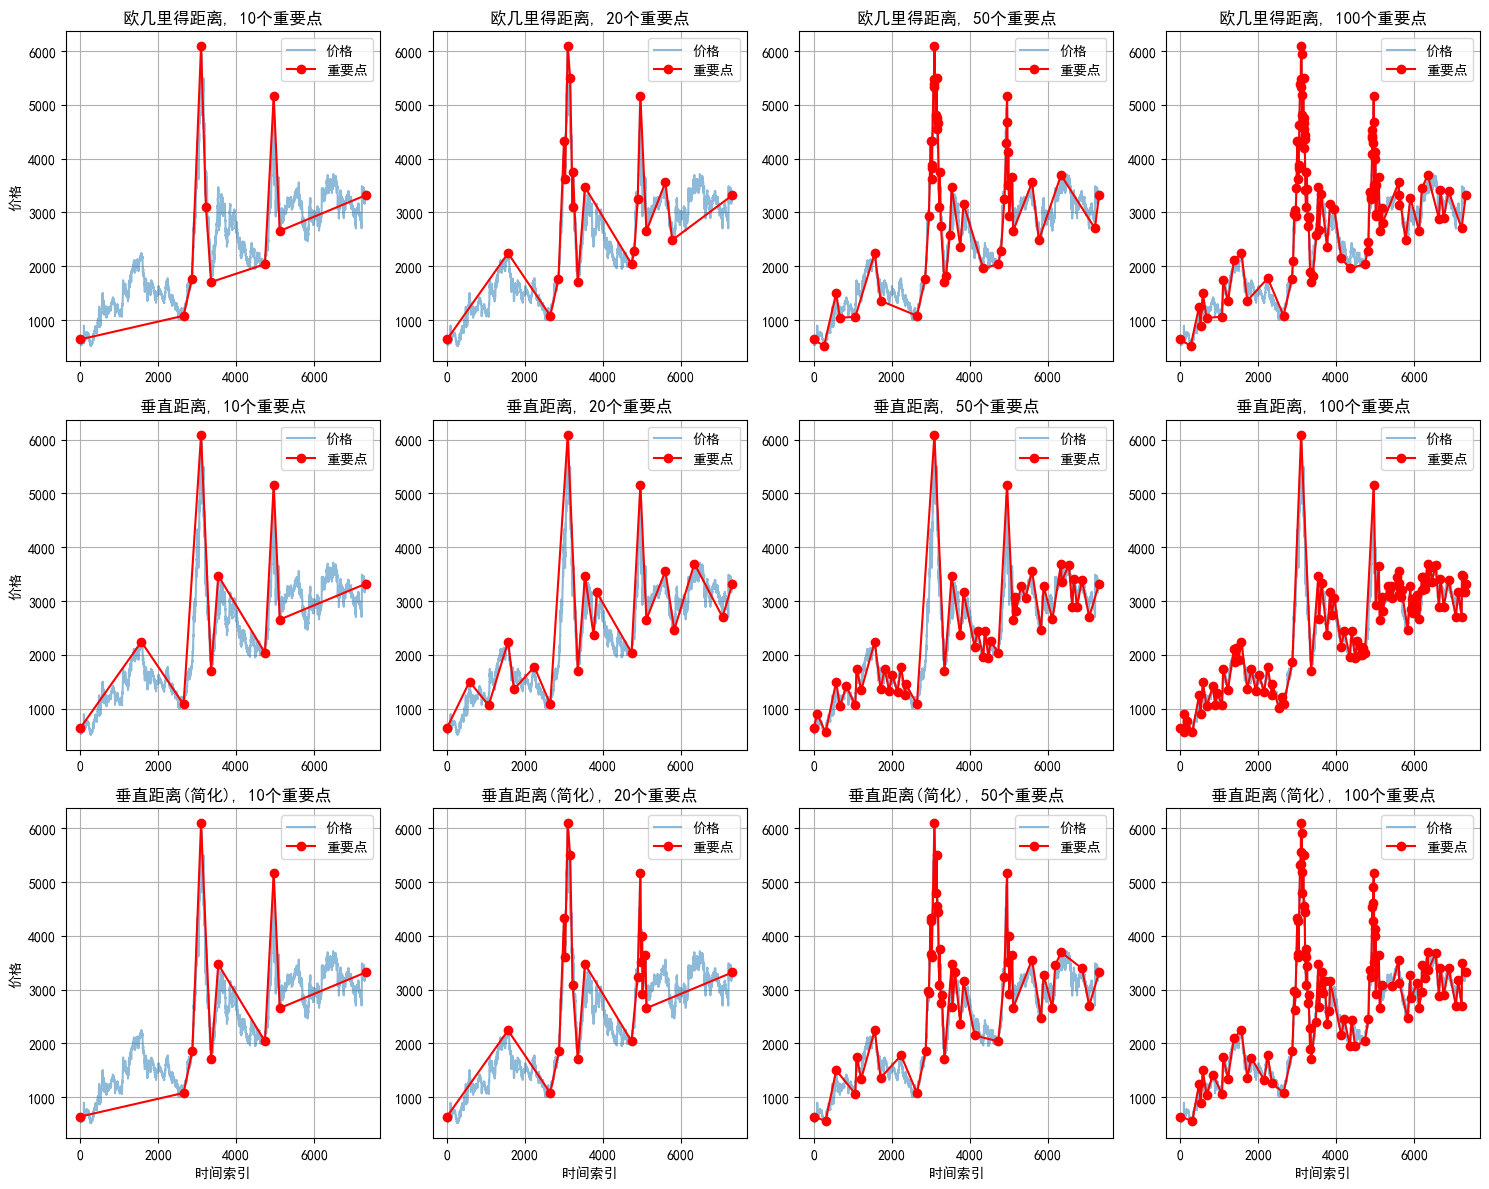

In [9]:
# # 创建不同参数组合的对比图
# n_pips_list = [10, 20, 50, 100]  # 不同数量的重要点用于比较效果

# # 使用不同的距离度量方式
# dist_measures = {
#     1: "欧几里得距离",
#     2: "垂直距离", 
#     3: "垂直距离(简化)"
# }

# # 获取收盘价数据
# price_data = data['Close'].to_numpy()

# # 创建一个大图表
# plt.figure(figsize=(15, 12))

# # 设置中文字体
# plt.rcParams['font.sans-serif'] = ['SimHei']  # 用来正常显示中文标签
# plt.rcParams['axes.unicode_minus'] = False     # 用来正常显示负号

# # 为每种距离度量方式和不同数量的重要点创建子图
# for i, dist_measure in enumerate(dist_measures.keys()):
#     for j, n_pips in enumerate(n_pips_list):
#         # 计算子图位置
#         subplot_idx = i * len(n_pips_list) + j + 1
        
#         # 创建子图
#         plt.subplot(len(dist_measures), len(n_pips_list), subplot_idx)
        
#         # 找出重要点
#         pips_x, pips_y = find_pips(price_data, n_pips, dist_measure)
        
#         # 绘制原始价格数据
#         plt.plot(range(len(price_data)), price_data, label='价格', alpha=0.5)
        
#         # 绘制重要点
#         plt.plot(pips_x, pips_y, 'ro-', label='重要点')
        
#         # 设置标题和标签
#         plt.title(f"{dist_measures[dist_measure]}, {n_pips}个重要点")
#         plt.grid(True)
        
#         # 只在最下面一行显示x轴标签
#         if i == len(dist_measures) - 1:
#             plt.xlabel('时间索引')
        
#         # 只在最左边一列显示y轴标签
#         if j == 0:
#             plt.ylabel('价格')
        
#         # 添加图例
#         plt.legend()

# plt.tight_layout()
# plt.show()

## 三、识别旗形

In [8]:
print("数据框的列名:", data.columns.tolist())

data.index

data = data_raw.copy()

data

数据框的列名: ['Close', 'Open', 'High', 'Low', 'Volume', 'Change']


,Close,Open,High,Low,Volume,Change
Date,,,,,,
1995-01-03,639.8800,637.7200,647.7100,630.5300,2.345180e+07,-1.233272
1995-01-04,653.8100,641.9000,655.5100,638.8600,4.222200e+07,2.176971
1995-01-05,646.8900,656.2000,657.4500,645.8100,4.301230e+07,-1.058411
1995-01-06,640.7600,642.7500,643.8900,636.3300,4.874820e+07,-0.947611
1995-01-09,625.9700,637.5200,637.5500,625.0400,5.098510e+07,-2.308197
...,...,...,...,...,...,...
2025-02-24,3373.0276,3374.0813,3384.8106,3355.8694,5.981882e+10,-0.180083
2025-02-25,3346.0398,3345.6534,3369.5583,3337.8448,5.275786e+10,-0.800106
2025-02-26,3380.2144,3351.2093,3380.2144,3351.2093,5.539920e+10,1.021345


<font color=steel size=5 face=雅黑>1.定义旗形</font>

In [94]:
import pandas as pd  # 用于数据处理和分析
import numpy as np   # 用于数值计算
import matplotlib.pyplot as plt  # 用于数据可视化
import mplfinance as mpf  # 用于绘制金融图表
# from perceptually_important import find_pips  # 导入感知重要点(PIP)识别函数
# from rolling_window import rw_top, rw_bottom  # 导入滚动窗口极值识别函数
from trendline_automation import fit_trendlines_single  # 导入趋势线拟合函数
from dataclasses import dataclass




# 这是Python的一个装饰器,用来简化类的定义。它会自动帮我们生成__init__()等基础方法,让我们只需要定义类的属性就可以了,不用写很多重复的代码。
#__init__()是类的构造函数,当我们创建类的实例时会自动调用它来初始化实例的属性。比如定义一个普通的类需要写构造函数,而用@dataclass就不用写了。
@dataclass  
class FlagPattern:  # 定义一个旗形模式类,用于存储和表示股票价格中的旗形形态特征
    """
    这是一个使用Python的dataclass装饰器定义的类，用于表示旗形和三角旗形态。
    @dataclass是Python的一个装饰器，它会自动为类生成特殊方法，如__init__、__repr__等，
    简化了数据类的创建过程，使代码更加简洁。
    """

    # 旗形和三角旗形态的数据结构
    
    # 属性:
    base_x: int         # 趋势起点索引，旗杆的底部
    base_y: float       # 趋势起点价格
    
    tip_x: int   = -1       # 旗杆顶部/底部索引，旗帜开始点。初始化为-1表示尚未找到有效的旗杆顶部/底部点
    tip_y: float = -1.      # 旗杆顶部/底部价格。初始化为-1表示尚未找到有效的价格点
    
    conf_x: int   = -1      # 形态确认点索引（突破点）
    conf_y: float = -1.     # 形态确认点价格
    
    pennant: bool = False   # True表示三角旗，False表示旗形
    
    flag_width: int    = -1    # 旗帜宽度（时间跨度）
    flag_height: float = -1.   # 旗帜高度（价格跨度）
    
    pole_width: int    = -1    # 旗杆宽度（时间跨度）
    pole_height: float = -1.   # 旗杆高度（价格跨度）
    
    # 旗帜的上下趋势线，截距在旗杆顶部/底部
    support_intercept: float = -1.  # 支撑线截距
    support_slope: float = -1.      # 支撑线斜率
    resist_intercept: float = -1.   # 阻力线截距
    resist_slope: float = -1.       # 阻力线斜率


def check_bear_pattern_pips(pending: FlagPattern, data: np.array, i:int, order:int):
    """
    检查熊市旗形/三角旗形态（基于PIP点方法）
    
    参数:
    pending: FlagPattern - 待填充的旗形对象
    data: np.array - 价格数据数组
    i: int - 当前检查的索引位置
    order: int - 滚动窗口大小参数
    
    返回:
    bool - 如果识别到有效形态则返回True，否则返回False
    """
    
    # 找出自局部顶部以来的最低价格（旗杆底部）
    # 从旗杆底部(pending.base_x)到当前检查位置(i)的数据切片
    # data[pending.base_x: i + 1]表示取数据从旗杆底部到当前位置的子集
    # i+1是因为在Python中切片的右边界是开区间,即不包含i+1这个位置
    
    # pending.base_x是旗杆底部的索引位置
    # 这行代码从旗杆底部(pending.base_x)到当前检查位置(i)提取了一段数据
    # i+1是因为切片右边界是开区间,所以需要+1才能包含i这个位置
    data_slice = data[pending.base_x: i + 1]  
    
    # 切片(slice)是从数组中提取一段连续数据的操作
    # 例如data_slice = data[pending.base_x: i + 1]就是一个切片操作
    # 它从原始数组data中提取了从pending.base_x到i的这一段数据
    # argmin()返回切片中最小值的索引位置
    # 由于切片是原始数组的一部分,所以需要加上切片起点pending.base_x才是在原始数组中的实际位置
    min_i = data_slice.argmin() + pending.base_x  # 自局部顶部以来的最低点索引
    
    # 确保从最低点到当前位置有足够的距离来形成旗帜
    if i - min_i < max(5, order * 0.5):  # 这行代码检查当前位置i到最低点min_i的距离是否小于两个值中的较大值:
                                         # 1. 固定值5
                                         # 2. order参数的一半
                                         # 如果距离太小,说明还没有形成足够宽的旗形形态,返回False
        return False
    
    # 测试旗帜宽度/高度
    pole_width = min_i - pending.base_x  # 旗杆宽度
    flag_width = i - min_i  # 旗帜宽度
    # 旗帜宽度应小于旗杆宽度的一半
    if flag_width > pole_width * 0.5:
        return False

    pole_height = pending.base_y - data[min_i]  # 旗杆高度
    flag_height = data[min_i:i+1].max() - data[min_i]  # 旗帜高度
    # 旗帜高度应小于旗杆高度的一半
    if flag_height > pole_height * 0.5:
        return False

    # 到这里，宽度/高度检查通过
    
    # 找出旗帜部分的感知重要点(PIP)
    # 找出从最低点到当前索引之间的5个PIP点
    # 5表示要找出5个重要点位(PIP点)
    # 3表示寻找重要点位时使用的滚动窗口大小
    pips_x, pips_y = find_pips(data[min_i:i+1], 5, 3)

    # 检查中心PIP点是否低于相邻的两个点，形成/\/\形状
    if not (pips_y[2] < pips_y[1] and pips_y[2] < pips_y[3]):
        return False
    
    # 计算旗帜的支撑线和阻力线
    # 支撑线：连接第1个和第3个PIP点
    support_rise = pips_y[2] - pips_y[0]  # 支撑线上升高度
    support_run = pips_x[2] - pips_x[0]  # 支撑线水平距离
    support_slope = support_rise / support_run  # 支撑线斜率
    support_intercept = pips_y[0]  # 支撑线截距
    
    # 阻力线：连接第2个和第4个PIP点
    resist_rise = pips_y[3] - pips_y[1]  # 阻力线上升高度
    resist_run = pips_x[3] - pips_x[1]  # 阻力线水平距离
    resist_slope = resist_rise / resist_run  # 阻力线斜率
    resist_intercept = pips_y[1] + (pips_x[0] - pips_x[1]) * resist_slope  # 阻力线截距

    # 计算两条线的交点
    if resist_slope != support_slope:  # 非平行线
        intersection = (support_intercept - resist_intercept) / (resist_slope - support_slope)
    else:
        intersection = -flag_width * 100  # 平行线，设置一个远离旗帜区域的交点

    # 如果交点在旗帜区域内，则不是有效的旗形/三角旗
    if intersection <= pips_x[4] and intersection >= 0:
        return False

    # 检查当前点是否突破旗帜下边界（支撑线），确认形态
    support_endpoint = pips_y[0] + support_slope * pips_x[4]
    if pips_y[4] > support_endpoint:  # 如果价格高于支撑线，则未突破
        return False
    
    # 判断是旗形还是三角旗
    # 如果阻力线向下倾斜（斜率为负），则为三角旗
    if resist_slope < 0:
        pending.pennant = True
    else:
        pending.pennant = False
    
    # 过滤严重发散的线（交点太近）
    if intersection < 0 and intersection > -flag_width:
        return False

    # 形态确认，填充旗形对象的属性
    pending.tip_x = min_i  # 旗杆底部索引
    pending.tip_y = data[min_i]  # 旗杆底部价格
    pending.conf_x = i  # 确认点索引
    pending.conf_y = data[i]  # 确认点价格
    pending.flag_width = flag_width  # 旗帜宽度
    pending.flag_height = flag_height  # 旗帜高度
    pending.pole_width = pole_width  # 旗杆宽度
    pending.pole_height = pole_height  # 旗杆高度
    pending.support_slope = support_slope  # 支撑线斜率
    pending.support_intercept = support_intercept  # 支撑线截距
    pending.resist_slope = resist_slope  # 阻力线斜率
    pending.resist_intercept = resist_intercept  # 阻力线截距
    
    return True  # 返回True表示识别到有效形态
    

def check_bull_pattern_pips(pending: FlagPattern, data: np.array, i:int, order:int):
    """
    检查牛市旗形/三角旗形态（基于PIP点方法）
    
    参数:
    pending: FlagPattern - 待填充的旗形对象
    pending: FlagPattern是一个参数声明，表示一个待处理的旗形模式对象。
    这里的pending是参数名，FlagPattern是类型标注，用于存储旗形形态的各种属性（如旗杆高度、宽度等）和状态信息。
    这个对象会在形态识别过程中被逐步填充完整。
    data: np.array - 价格数据数组
    i: int - 当前检查的索引位置
    order: int - 滚动窗口大小参数
    
    返回:
    bool - 如果识别到有效形态则返回True，否则返回False
    """
    
    # 找出自局部底部以来的最高价格（旗杆顶部）
    # 这行代码从价格数组data中提取了从pending.base_x（局部底部）到i+1（当前位置）的一段数据。i+1是为了包含当前价格点，因为Python切片是左闭右开的。
    data_slice = data[pending.base_x: i + 1]  # i + 1包含当前价格

    # 这行代码在寻找从局部底部到当前位置之间的最高价格点的索引。
    # data_slice.argmax()找到切片中最高价格的位置，加上pending.base_x是为了将这个相对位置转换为在原始数组中的绝对位置。这个索引将用于确定旗杆的顶部位置。
    max_i = data_slice.argmax() + pending.base_x  # 自局部底部以来的最高点索引
    pole_width = max_i - pending.base_x  # 旗杆宽度
    
    # 确保从最高点到当前位置有足够的距离来形成旗帜
    if i - max_i < max(5, order * 0.5):
        return False

    # 测试旗帜宽度/高度
    flag_width = i - max_i  # 旗帜宽度
    # 旗帜宽度应小于旗杆宽度的一半
    if flag_width > pole_width * 0.5:
        return False

    pole_height = data[max_i] - pending.base_y  # 旗杆高度
    flag_height = data[max_i] - data[max_i:i+1].min()  # 旗帜高度
    # 旗帜高度应小于旗杆高度的一半
    if flag_height > pole_height * 0.5:
        return False

    # 找出旗帜部分的感知重要点(PIP)
    # 找出从最高点到当前索引之间的5个PIP点
    # pips_y[0]是第一个PIP点的价格,代表旗帜区域的起始点
    # pips_y[4]是最后一个PIP点的价格,代表当前价格点
    pips_x, pips_y = find_pips(data[max_i:i+1], 5, 3)  

    # 检查中心PIP点是否高于相邻的两个点，形成\/\/形状
    if not (pips_y[2] > pips_y[1] and pips_y[2] > pips_y[3]):
        return False
        
    # 计算旗帜的阻力线和支撑线
    # 阻力线：连接第1个和第3个PIP点
    # 计算阻力线的上升高度，即第3个PIP点(pips_y[2])与第1个PIP点(pips_y[0])的垂直距离
    resist_rise = pips_y[2] - pips_y[0]  # 阻力线上升高度
    
    # 计算阻力线的水平距离，即第3个PIP点(pips_x[2])与第1个PIP点(pips_x[0])的水平距离
    resist_run = pips_x[2] - pips_x[0]  # 阻力线水平距离
    
    # 计算阻力线的斜率，使用上升高度除以水平距离
    # 斜率为正表示向上倾斜，为负表示向下倾斜
    resist_slope = resist_rise / resist_run  # 阻力线斜率
    
    # 计算阻力线的截距，即阻力线与y轴的交点
    # 这里直接使用第1个PIP点的y值作为截距
    resist_intercept = pips_y[0]  # 阻力线截距

    # 支撑线：连接第2个和第4个PIP点
    support_rise = pips_y[3] - pips_y[1]  # 支撑线上升高度
    support_run = pips_x[3] - pips_x[1]  # 支撑线水平距离
    support_slope = support_rise / support_run  # 支撑线斜率
    support_intercept = pips_y[1] + (pips_x[0] - pips_x[1]) * support_slope  # 支撑线截距

    # 计算两条线的交点
    if resist_slope != support_slope:  # 非平行线
        # 计算支撑线和阻力线的交点的x坐标
        # 使用两条直线方程联立求解:
        # y = resist_slope * x + resist_intercept
        # y = support_slope * x + support_intercept
        # 解出x坐标(intersection)
        intersection = (support_intercept - resist_intercept) / (resist_slope - support_slope)
    else:
        # 当支撑线和阻力线平行时,将交点设置在旗帜区域左侧很远的位置
        # 这样做是为了确保交点不会落在旗帜区域内
        # flag_width是旗帜的宽度,乘以100是为了将交点设得足够远
        intersection = -flag_width * 100  # 平行线，设置一个远离旗帜区域的交点

    # 如果交点在旗帜区域内，则不是有效的旗形/三角旗
    # 因为有效的旗形/三角旗的支撑线和阻力线应该在旗帜区域外相交
    # 如果在旗帜区域内相交，说明两条趋势线收敛太快，形成的是一个楔形形态而不是旗形
    # 楔形形态通常代表趋势的延续或反转，而旗形则代表趋势的暂时休整
    if intersection <= pips_x[4] and intersection >= 0:
        return False
    
    # 过滤严重发散的线（交点太近）
    # 如果交点在旗帜宽度的负1倍范围内,说明两条趋势线发散得太快,不是有效形态
    # 例如:如果旗帜宽度为10,那么交点应该在x<-10的位置,否则说明趋势线发散太快
    if intersection < 0 and intersection > -1.0 * flag_width:
        return False

    # 检查当前点是否突破旗帜上边界（阻力线），确认形态
    resist_endpoint = pips_y[0] + resist_slope * pips_x[4]
    if pips_y[4] < resist_endpoint:  # 如果价格低于阻力线，则未突破
        return False

    # 判断是旗形还是三角旗
    # 如果支撑线向上倾斜（斜率为正），则为三角旗
    if support_slope > 0:
        pending.pennant = True
    else:
        pending.pennant = False

    # 形态确认，填充旗形对象的属性
    pending.tip_x = max_i  # 旗杆顶部索引
    pending.tip_y = data[max_i]  # 旗杆顶部价格
    pending.conf_x = i  # 确认点索引
    pending.conf_y = data[i]  # 确认点价格
    pending.flag_width = flag_width  # 旗帜宽度
    pending.flag_height = flag_height  # 旗帜高度
    pending.pole_width = pole_width  # 旗杆宽度
    pending.pole_height = pole_height  # 旗杆高度
    
    pending.support_slope = support_slope  # 支撑线斜率
    pending.support_intercept = support_intercept  # 支撑线截距

    pending.resist_slope = resist_slope  # 阻力线斜率
    pending.resist_intercept = resist_intercept  # 阻力线截距
    
    return True  # 返回True表示识别到有效形态


def find_flags_pennants_pips(data: np.array, order:int):
    """
    基于PIP点方法识别旗形和三角旗形态
    
    参数:
    data: np.array - 价格数据数组
    order: int - 滚动窗口大小参数，用于识别局部极值
    
    返回:
    bull_flags: list - 牛市旗形列表
    bear_flags: list - 熊市旗形列表
    bull_pennants: list - 牛市三角旗列表
    bear_pennants: list - 熊市三角旗列表
    """
    assert(order >= 3)  # 确保窗口大小参数至少为3
    pending_bull = None  # 待处理的牛市形态
    pending_bear = None  # 待处理的熊市形态

    # 初始化结果列表
    bull_pennants = []  # 牛市三角旗列表
    bear_pennants = []  # 熊市三角旗列表
    bull_flags = []     # 牛市旗形列表
    bear_flags = []     # 熊市旗形列表
    
    '''
    因为：
    熊旗形态是从高点开始向下运动，所以需要从局部高点开始寻找
    牛旗形态是从低点开始向上运动，所以需要从局部低点开始寻找
    这符合市场趋势的基本原理 - 熊市从高点下跌，牛市从低点上涨。
        
    '''

    # 遍历价格数据 len(data)返回7320，而range()函数生成的序列是从0开始到结束值-1，所以i的取值范围是0到7319。这与数据帧的7320行数据相对应。
    for i in range(len(data)):# range(len(data))的取值范围是从0到7319，因为根据上下文中的数据帧输出显示总共有7320行数据（[7320 rows x 6 columns]）。

        # 识别局部极值点作为形态起点
        '''
        rw_top(data, i, order)函数会检查i-order位置的点是否是在[i-2*order, i]这个窗口范围内的局部高点。
        也就是说，它需要等待后续order个点的数据才能确认i-order位置是否真的是局部高点。
        这样设计是为了避免在实时分析中的"提前预知"问题。
        '''
        if rw_top(data, i, order):   # 如果是局部高点，i是当前遍历到的数据点的索引，order参数为12，表示在前后各12个点(共25个点，包括当前点)的范围内是最高点
        # 创建新的熊市形态对象，以当前高点为起点
        # 代码在每次检测到局部高点时(rw_top返回True)，就会创建一个新的熊市旗形对象(pending_bear)。这是因为每个高点都可能是潜在的熊市旗形或三角旗形态的起点。
        # FlagPattern是一个类，这里创建了该类的实例，传入两个参数：
        # 第一个参数i - order：形态的基准点位置（索引）
        # 第二个参数data[i - order]：该位置对应的价格值
        # 这两个值会被存储为对象的base_x和base_y属性，用于后续旗形形态的识别和分析。
        # 构造函数只初始化了base_x和base_y这两个属性，其余13个属性此时都是空值。这些属性会在后续的check_bull_pattern_pips或check_bear_pattern_pips函数中被赋值。

        # 代码在每次检测到局部高点时(rw_top返回True)，就会创建一个新的熊市旗形对象(pending_bear)。这是因为每个高点都可能是潜在的熊市旗形或三角旗形态的起点。
            pending_bear = FlagPattern(i - order, data[i - order])
        if rw_bottom(data, i, order):  # 如果是局部低点
            # 创建新的牛市形态对象，以当前低点为起点
            pending_bull = FlagPattern(i - order, data[i - order])

        # 检查并处理待处理的熊市形态
        if pending_bear is not None:
            # 检查是否形成熊市旗形/三角旗
            if check_bear_pattern_pips(pending_bear, data, i, order):
                # 根据形态类型添加到相应列表
                if pending_bear.pennant:
                    bear_pennants.append(pending_bear)  # 添加熊市三角旗
                else:
                    bear_flags.append(pending_bear)     # 添加熊市旗形
                pending_bear = None  # 重置待处理形态

        # 检查并处理待处理的牛市形态
        if pending_bull is not None:
            # 检查是否形成牛市旗形/三角旗
            if check_bull_pattern_pips(pending_bull, data, i, order):
                # 根据形态类型添加到相应列表
                if pending_bull.pennant:
                    bull_pennants.append(pending_bull)  # 添加牛市三角旗
                else:
                    bull_flags.append(pending_bull)     # 添加牛市旗形
                pending_bull = None  # 重置待处理形态

    # 返回识别结果
    return bull_flags, bear_flags, bull_pennants, bear_pennants


def check_bull_pattern_trendline(pending: FlagPattern, data: np.array, i:int, order:int):
    """
    检查牛市旗形/三角旗形态（基于趋势线方法）
    
    参数:
    pending: FlagPattern - 待填充的旗形对象
    data: np.array - 价格数据数组
    i: int - 当前检查的索引位置
    order: int - 滚动窗口大小参数
    
    返回:
    bool - 如果识别到有效形态则返回True，否则返回False
    """
    
    # 检查旗杆顶部之后的价格是否超过旗杆顶部价格
    if data[pending.tip_x + 1 : i].max() > pending.tip_y:
        return False

    # 找出旗帜部分的最低价格
    flag_min = data[pending.tip_x:i].min()

    # 计算旗杆和旗帜的高度和宽度
    pole_height = pending.tip_y - pending.base_y  # 旗杆高度
    pole_width = pending.tip_x - pending.base_x   # 旗杆宽度
    
    flag_height = pending.tip_y - flag_min  # 旗帜高度
    flag_width = i - pending.tip_x          # 旗帜宽度

    # 旗帜宽度应小于旗杆宽度的一半
    if flag_width > pole_width * 0.5:
        return False

    # 旗帜高度应小于旗杆高度的75%
    if flag_height > pole_height * 0.75:
        return False

    # 使用趋势线拟合算法找出旗帜部分的支撑线和阻力线
    support_coefs, resist_coefs = fit_trendlines_single(data[pending.tip_x:i])
    support_slope, support_intercept = support_coefs[0], support_coefs[1]  # 支撑线系数
    resist_slope, resist_intercept = resist_coefs[0], resist_coefs[1]      # 阻力线系数

    # 检查当前价格是否突破上趋势线（阻力线），确认形态
    current_resist = resist_intercept + resist_slope * (flag_width + 1)
    if data[i] <= current_resist:  # 如果价格未突破阻力线
        return False

    # 判断是旗形还是三角旗
    # 如果支撑线向上倾斜（斜率为正），则为三角旗
    if support_slope > 0:
        pending.pennant = True
    else:
        pending.pennant = False

    # 形态确认，填充旗形对象的属性
    pending.conf_x = i  # 确认点索引
    pending.conf_y = data[i]  # 确认点价格
    pending.flag_width = flag_width  # 旗帜宽度
    pending.flag_height = flag_height  # 旗帜高度
    pending.pole_width = pole_width  # 旗杆宽度
    pending.pole_height = pole_height  # 旗杆高度
    
    pending.support_slope = support_slope  # 支撑线斜率
    pending.support_intercept = support_intercept  # 支撑线截距
    pending.resist_slope = resist_slope  # 阻力线斜率
    pending.resist_intercept = resist_intercept  # 阻力线截距

    return True  # 返回True表示识别到有效形态

def check_bear_pattern_trendline(pending: FlagPattern, data: np.array, i:int, order:int):
    """
    检查熊市旗形/三角旗形态（基于趋势线方法）
    
    参数:
    pending: FlagPattern - 待填充的旗形对象
    data: np.array - 价格数据数组
    i: int - 当前检查的索引位置
    order: int - 滚动窗口大小参数
    
    返回:
    bool - 如果识别到有效形态则返回True，否则返回False
    """
    
    # 检查旗杆底部之后的价格是否低于旗杆底部价格
    if data[pending.tip_x + 1 : i].min() < pending.tip_y:
        return False

    # 找出旗帜部分的最高价格
    flag_max = data[pending.tip_x:i].max()

    # 计算旗杆和旗帜的高度和宽度
    pole_height = pending.base_y - pending.tip_y  # 旗杆高度
    pole_width = pending.tip_x - pending.base_x   # 旗杆宽度
    
    flag_height = flag_max - pending.tip_y  # 旗帜高度
    flag_width = i - pending.tip_x          # 旗帜宽度

    # 旗帜宽度应小于旗杆宽度的一半
    if flag_width > pole_width * 0.5:
        return False

    # 旗帜高度应小于旗杆高度的75%
    if flag_height > pole_height * 0.75:
        return False

    # 使用趋势线拟合算法找出旗帜部分的支撑线和阻力线
    support_coefs, resist_coefs = fit_trendlines_single(data[pending.tip_x:i])
    support_slope, support_intercept = support_coefs[0], support_coefs[1]  # 支撑线系数
    resist_slope, resist_intercept = resist_coefs[0], resist_coefs[1]      # 阻力线系数

    # 检查当前价格是否突破下趋势线（支撑线），确认形态
    current_support = support_intercept + support_slope * (flag_width + 1)
    if data[i] >= current_support:  # 如果价格未突破支撑线
        return False

    # 判断是旗形还是三角旗
    # 如果阻力线向下倾斜（斜率为负），则为三角旗
    if resist_slope < 0:
        pending.pennant = True
    else:
        pending.pennant = False

    # 形态确认，填充旗形对象的属性
    pending.conf_x = i  # 确认点索引
    pending.conf_y = data[i]  # 确认点价格
    pending.flag_width = flag_width  # 旗帜宽度
    pending.flag_height = flag_height  # 旗帜高度
    pending.pole_width = pole_width  # 旗杆宽度
    pending.pole_height = pole_height  # 旗杆高度
    
    pending.support_slope = support_slope  # 支撑线斜率
    pending.support_intercept = support_intercept  # 支撑线截距
    pending.resist_slope = resist_slope  # 阻力线斜率
    pending.resist_intercept = resist_intercept  # 阻力线截距

    return True  # 返回True表示识别到有效形态

def find_flags_pennants_trendline(data: np.array, order:int):
    """
    基于趋势线方法识别旗形和三角旗形态
    
    参数:
    data: np.array - 价格数据数组
    order: int - 滚动窗口大小参数，用于识别局部极值
    
    返回:
    bull_flags: list - 牛市旗形列表
    bear_flags: list - 熊市旗形列表
    bull_pennants: list - 牛市三角旗列表
    bear_pennants: list - 熊市三角旗列表
    """
    last_bottom = -1  # 最近的局部底部索引
    last_top = -1     # 最近的局部顶部索引
    pending_bull = None  # 待处理的牛市形态
    pending_bear = None  # 待处理的熊市形态

    # 初始化结果列表
    bull_pennants = []  # 牛市三角旗列表
    bear_pennants = []  # 熊市三角旗列表
    bull_flags = []     # 牛市旗形列表
    bear_flags = []     # 熊市旗形列表
    
    # 遍历价格数据
    for i in range(len(data)):

        # 识别局部极值点
        if rw_top(data, i, order):  # 如果是局部高点
            last_top = i - order  # 更新最近的局部顶部索引
            if last_bottom != -1:  # 如果已有局部底部
                # 创建新的牛市形态对象，从底部到顶部
                pending = FlagPattern(last_bottom, data[last_bottom])
                pending.tip_x = last_top  # 设置旗杆顶部
                pending.tip_y = data[last_top]
                pending_bull = pending
        
        if rw_bottom(data, i, order):  # 如果是局部低点
            last_bottom = i - order  # 更新最近的局部底部索引
            if last_top != -1:  # 如果已有局部顶部
                # 创建新的熊市形态对象，从顶部到底部
                pending = FlagPattern(last_top, data[last_top])
                pending.tip_x = last_bottom  # 设置旗杆底部
                pending.tip_y = data[last_bottom]
                pending_bear = pending

        # 检查并处理待处理的熊市形态
        if pending_bear is not None:
            # 检查是否形成熊市旗形/三角旗
            if check_bear_pattern_trendline(pending_bear, data, i, order):
                # 根据形态类型添加到相应列表
                if pending_bear.pennant:
                    bear_pennants.append(pending_bear)  # 添加熊市三角旗
                else:
                    bear_flags.append(pending_bear)     # 添加熊市旗形
                pending_bear = None  # 重置待处理形态
        
        # 检查并处理待处理的牛市形态
        if pending_bull is not None:
            # 检查是否形成牛市旗形/三角旗
            if check_bull_pattern_trendline(pending_bull, data, i, order):
                # 根据形态类型添加到相应列表
                if pending_bull.pennant:
                    bull_pennants.append(pending_bull)  # 添加牛市三角旗
                else:
                    bull_flags.append(pending_bull)     # 添加牛市旗形
                pending_bull = None  # 重置待处理形态

    # 返回识别结果
    return bull_flags, bear_flags, bull_pennants, bear_pennants

def plot_flag(candle_data: pd.DataFrame, pattern: FlagPattern, pad=2):
    """
    绘制旗形/三角旗形态
    
    参数:
    candle_data: pd.DataFrame - K线数据
    pattern: FlagPattern - 旗形/三角旗对象
    pad: int - 图表两侧的额外空间
    """
    if pad < 0:
        pad = 0

    # 截取需要显示的数据范围
    start_i = pattern.base_x - pad
    end_i = pattern.conf_x + 1 + pad
    dat = candle_data.iloc[start_i:end_i]
    idx = dat.index
    
    # 设置绘图风格
    # 可用的style包括:
    # 'default', 'classic', 'Solarize_Light2', 'bmh', 'dark_background', 
    # 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'seaborn',
    # 'seaborn-bright', 'seaborn-colorblind', 'seaborn-dark',
    # 'seaborn-dark-palette', 'seaborn-darkgrid', 'seaborn-deep',
    # 'seaborn-muted', 'seaborn-notebook', 'seaborn-paper',
    # 'seaborn-pastel', 'seaborn-poster', 'seaborn-talk',
    # 'seaborn-ticks', 'seaborn-white', 'seaborn-whitegrid',
    # 'tableau-colorblind10'
    plt.style.use('seaborn-v0_8-bright')  
    fig = plt.gcf()
    ax = fig.gca()  # ax是matplotlib中的坐标轴对象,gca()表示获取当前图形的坐标轴(get current axes)

    # 获取关键点的索引
    tip_idx = idx[pattern.tip_x - start_i]  # 旗杆顶部/底部索引
    conf_idx = idx[pattern.conf_x - start_i]  # 确认点索引

    # 定义要绘制的线
    pole_line = [(idx[pattern.base_x - start_i], pattern.base_y), (tip_idx, pattern.tip_y)]  # 旗杆线
    upper_line = [(tip_idx, pattern.resist_intercept), (conf_idx, pattern.resist_intercept + pattern.resist_slope * pattern.flag_width)]  # 上趋势线
    lower_line = [(tip_idx, pattern.support_intercept), (conf_idx, pattern.support_intercept + pattern.support_slope * pattern.flag_width)]  # 下趋势线

    # 绘制K线图和趋势线
    # 设置K线图的颜色样式
    mc = mpf.make_marketcolors(up='red',          # 上涨蜡烛颜色
                              down='green',        # 下跌蜡烛颜色
                              edge='inherit',      # 边框颜色继承自up/down
                              volume='in',         # 成交量颜色跟随K线
                              wick='inherit')      # 上下影线继承自up/down
    
    # 创建自定义样式
    s = mpf.make_mpf_style(marketcolors=mc)
    
    # 绘制K线图和趋势线
    mpf.plot(dat, 
             alines=dict(alines=[pole_line, upper_line, lower_line], 
                        colors=['black', 'blue', 'blue']),  # 旗杆为黄色,趋势线为红色
             type='candle',
             style=s,
             ax=ax,
             datetime_format='%Y-%m-%d')  # 设置横坐标日期格式为 年-月-日
    plt.show()







<font color=steel size=5 face=雅黑>2.主程序&绘制每一个满足条件的旗形</font>


=== 牛市旗形形态统计 ===
共发现牛市旗形数量: 17


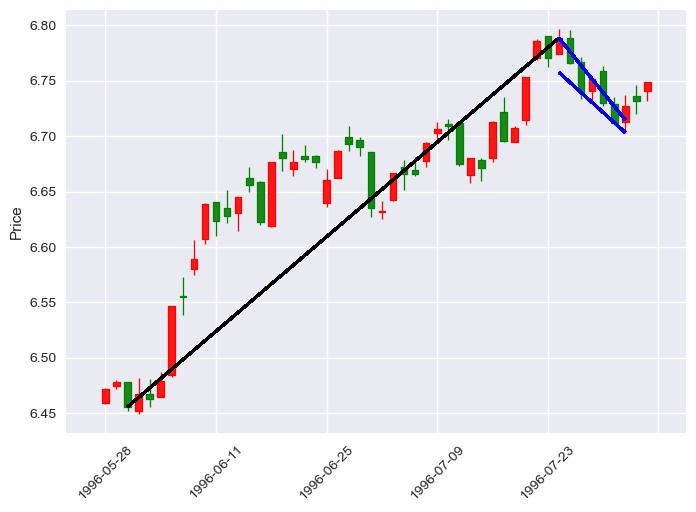

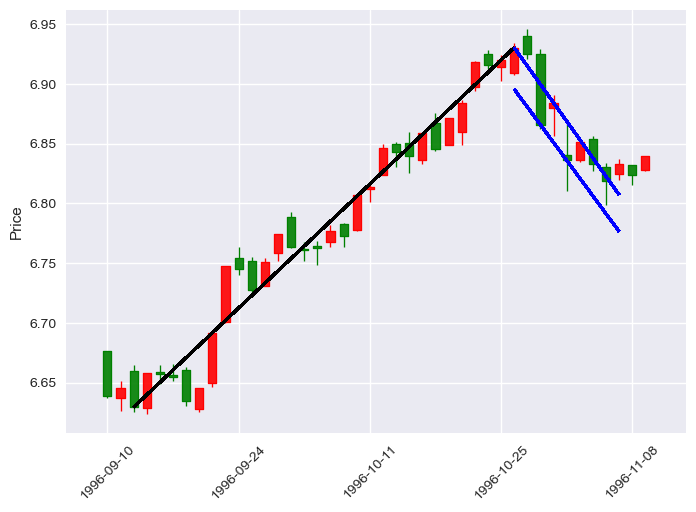

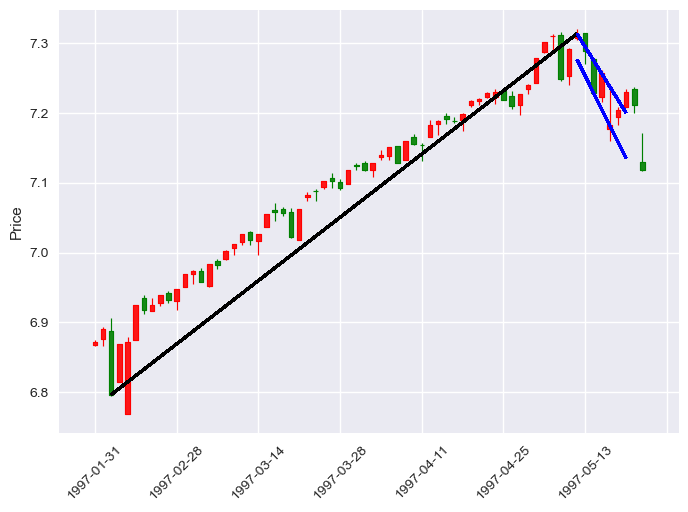

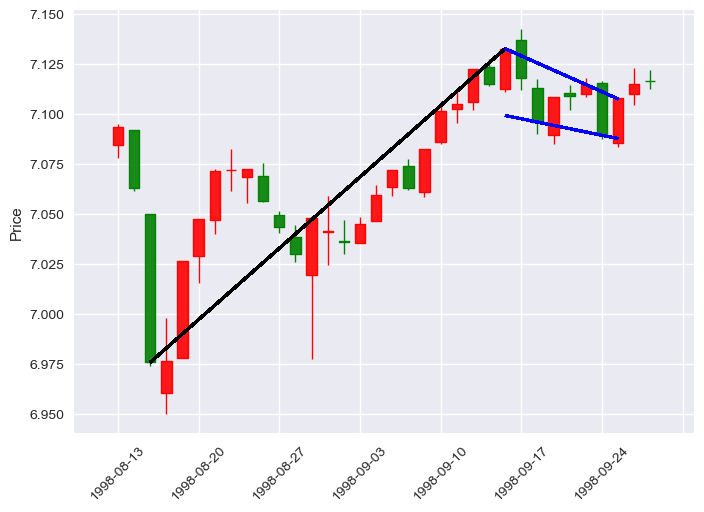

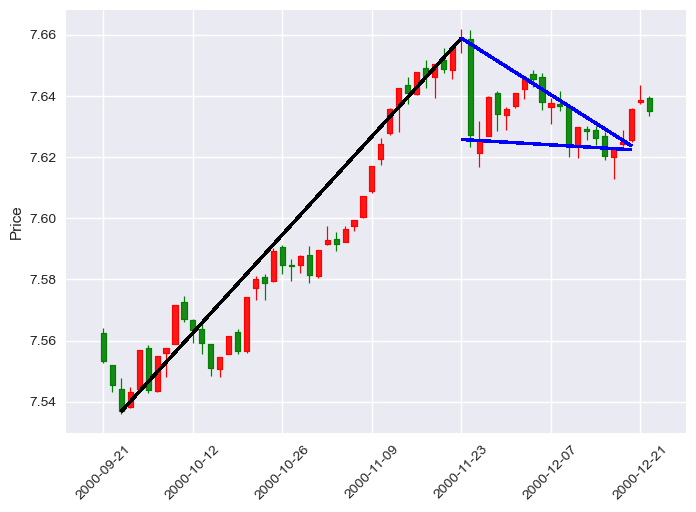

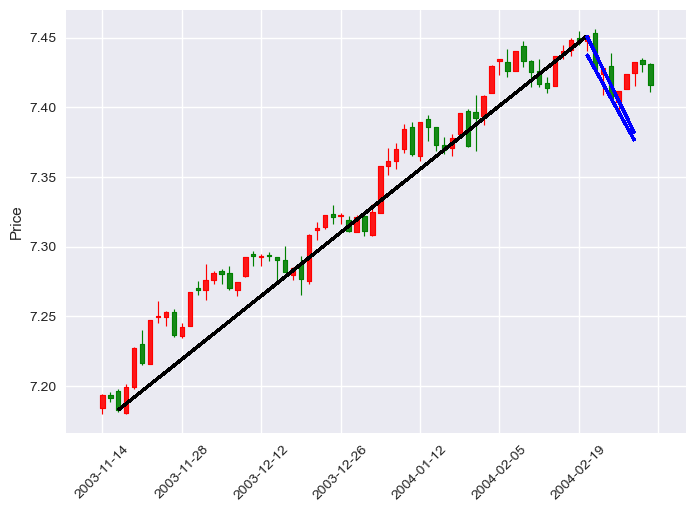

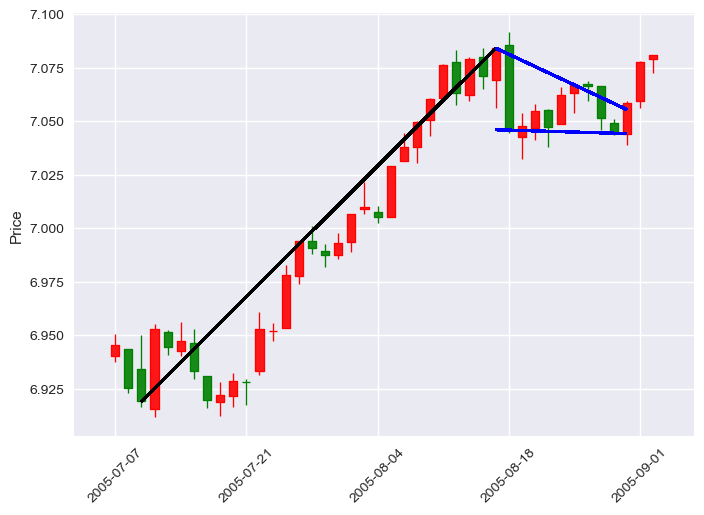

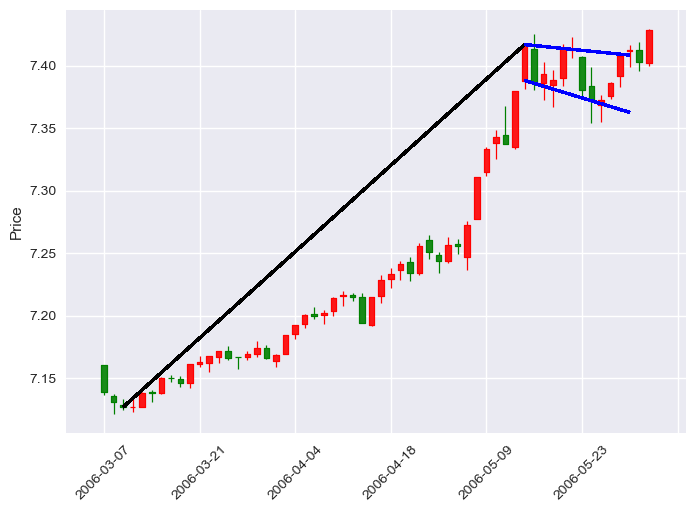

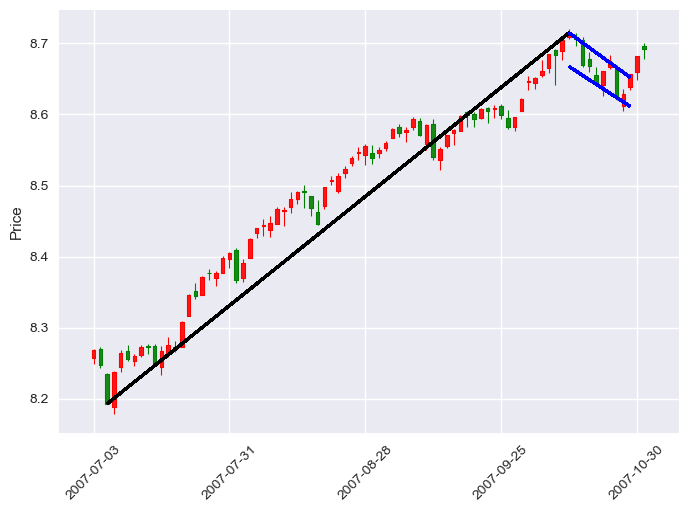

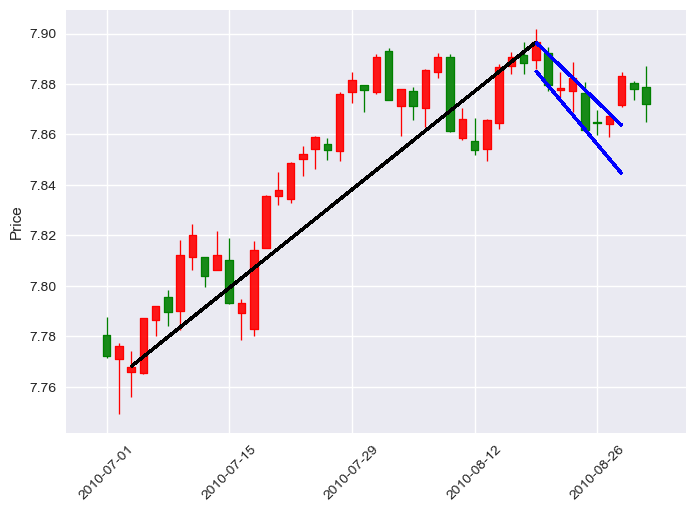

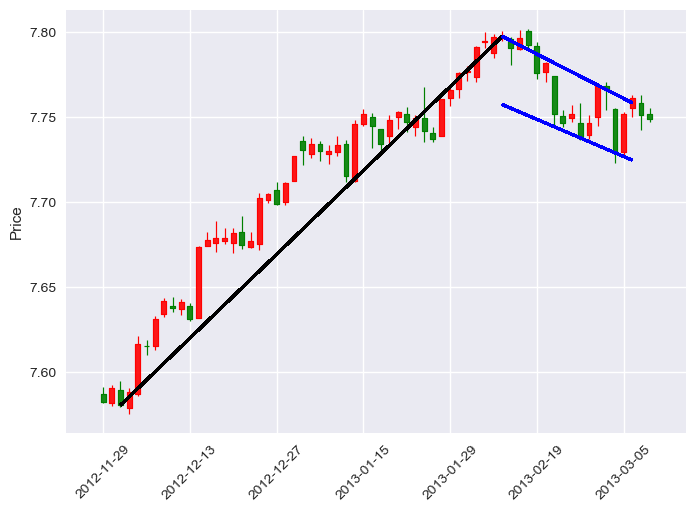

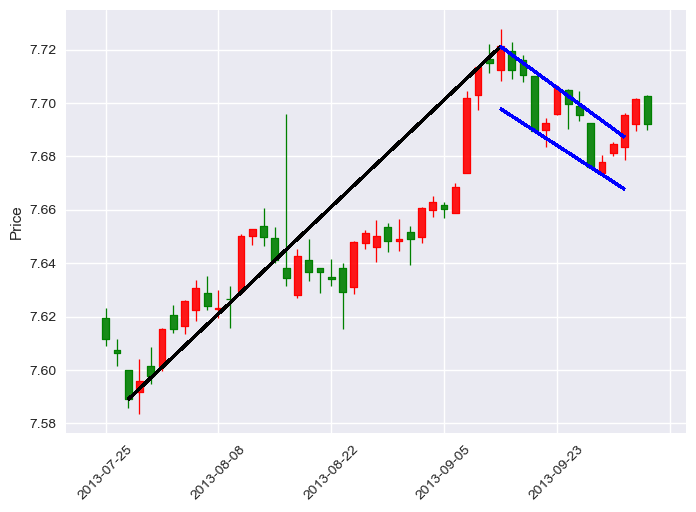

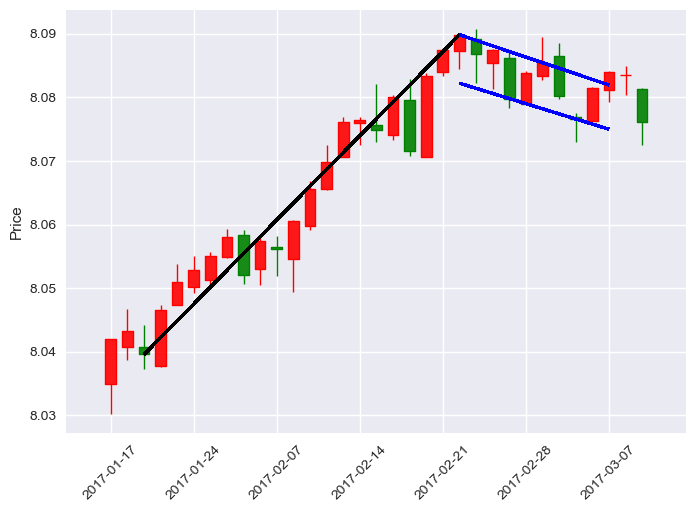

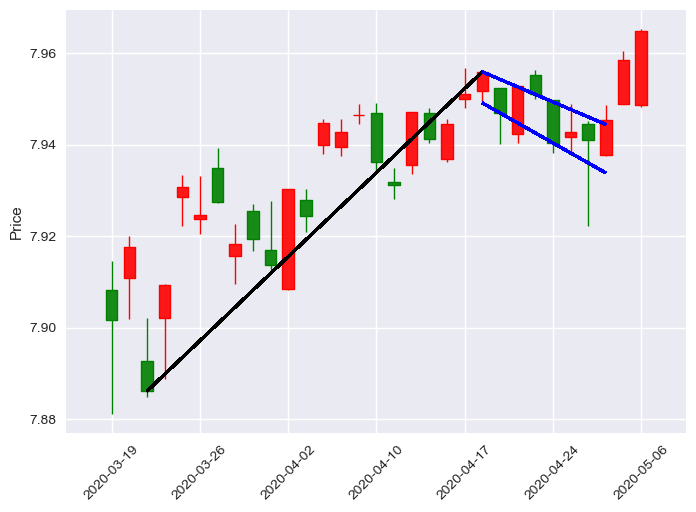

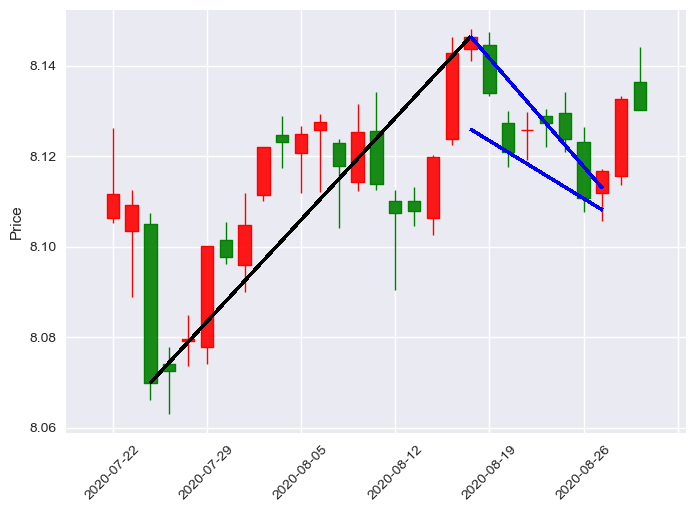

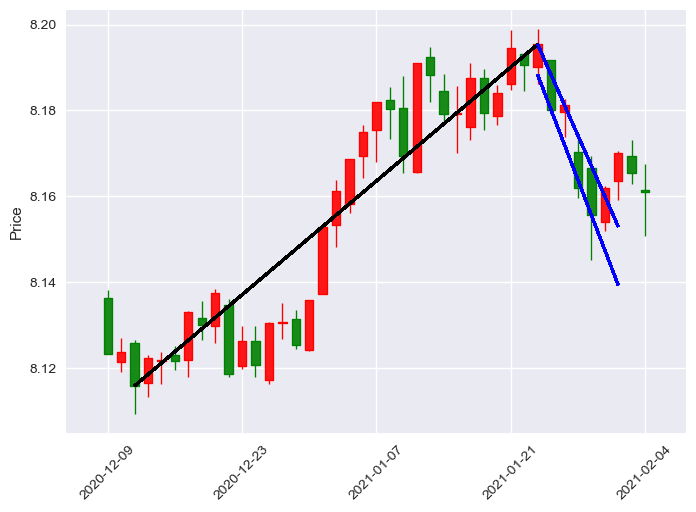

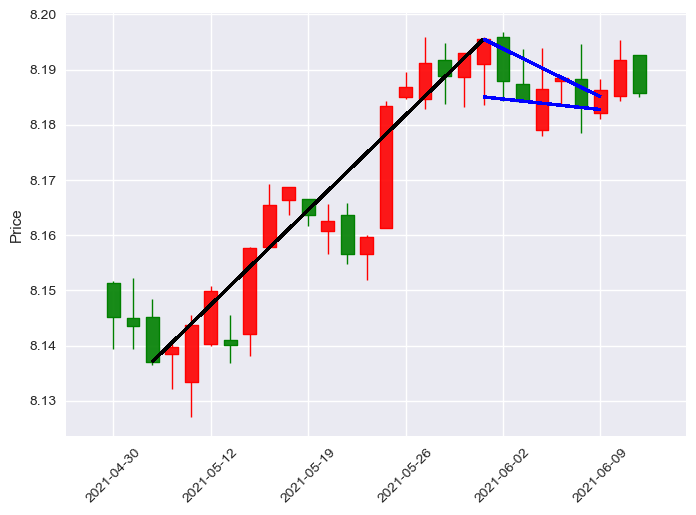


=== 熊市旗形形态统计 ===
共发现熊市旗形数量: 19


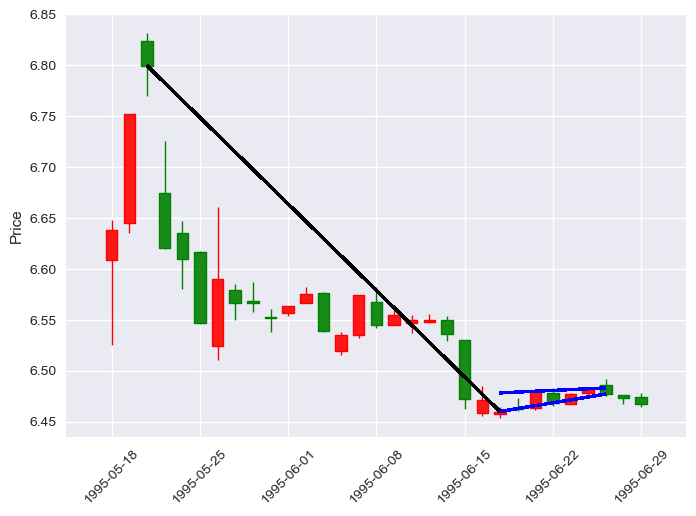

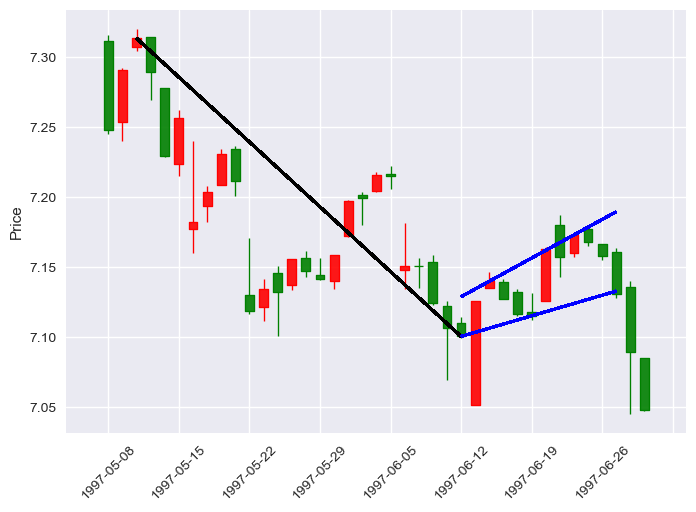

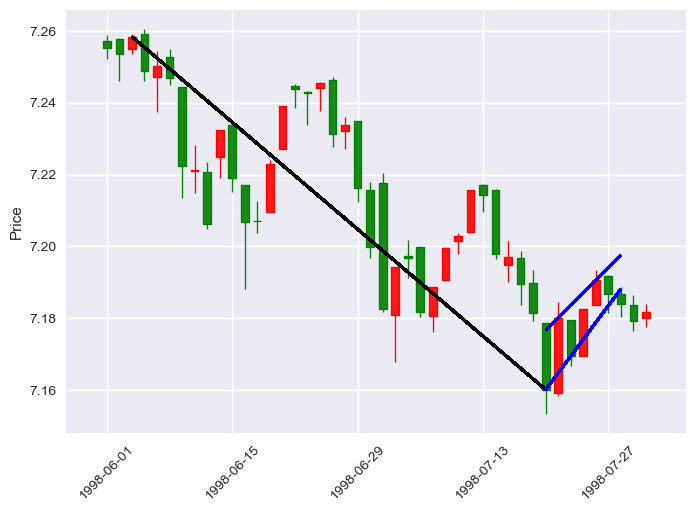

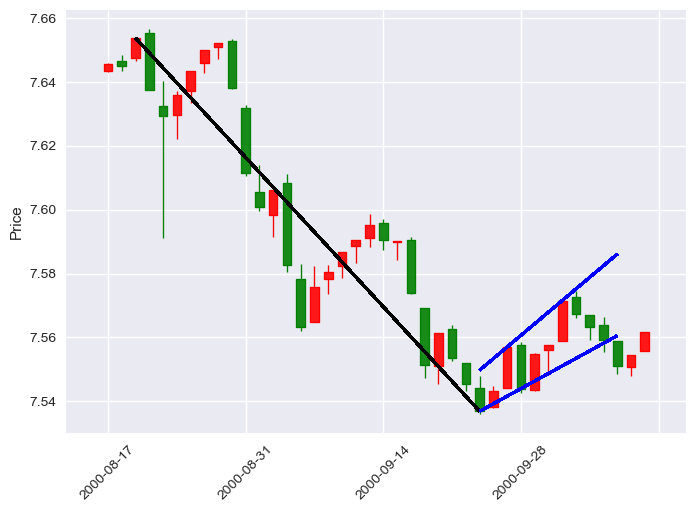

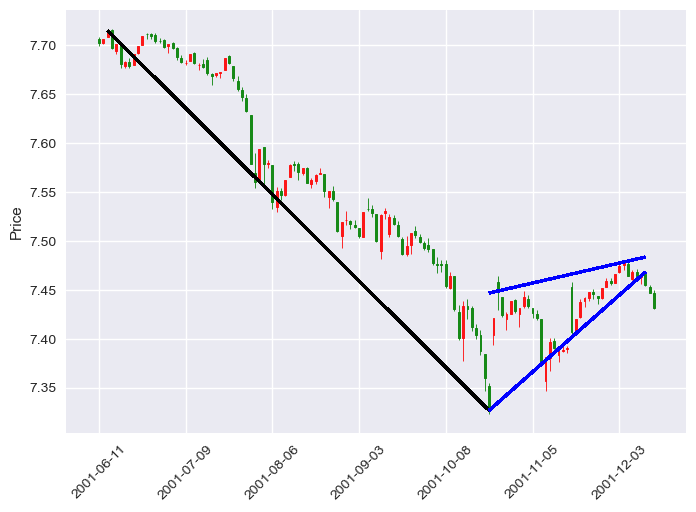

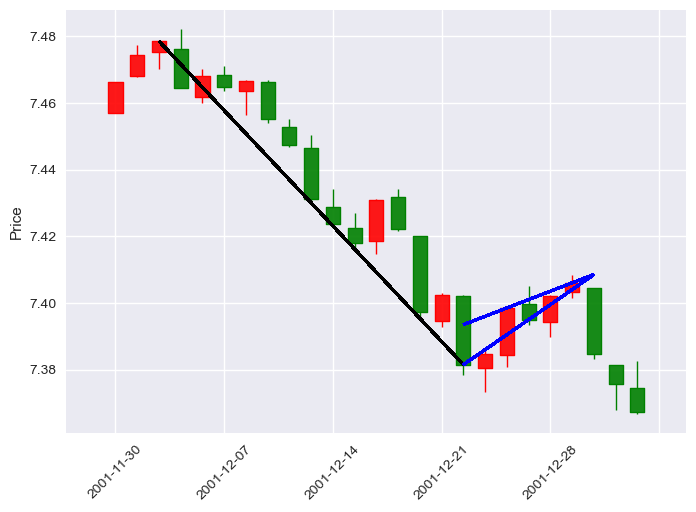

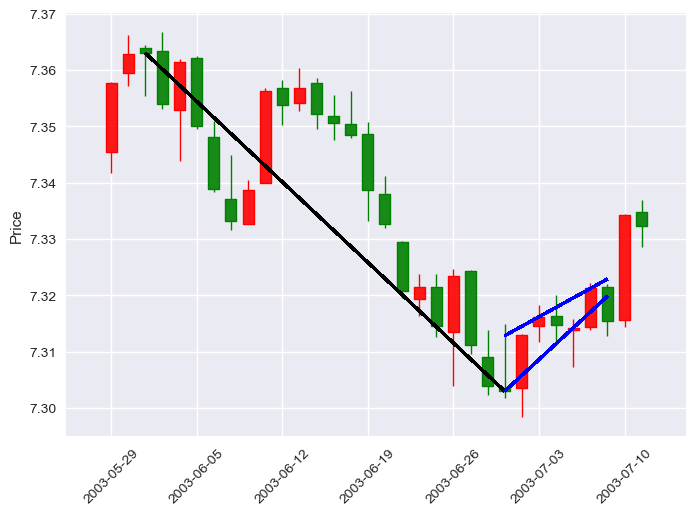

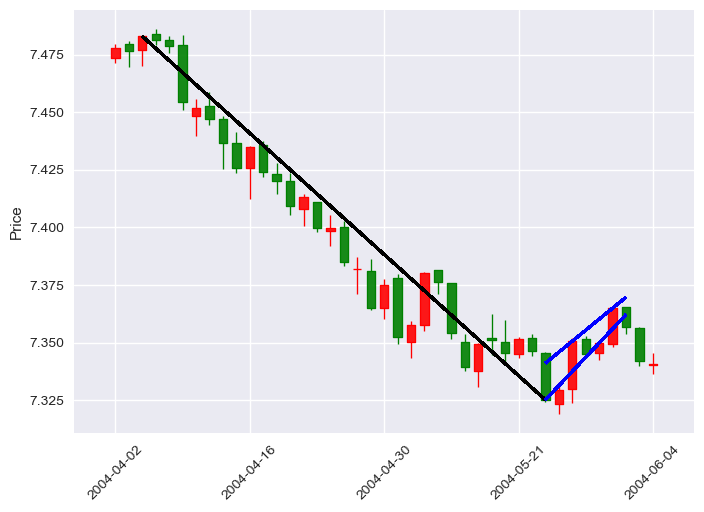

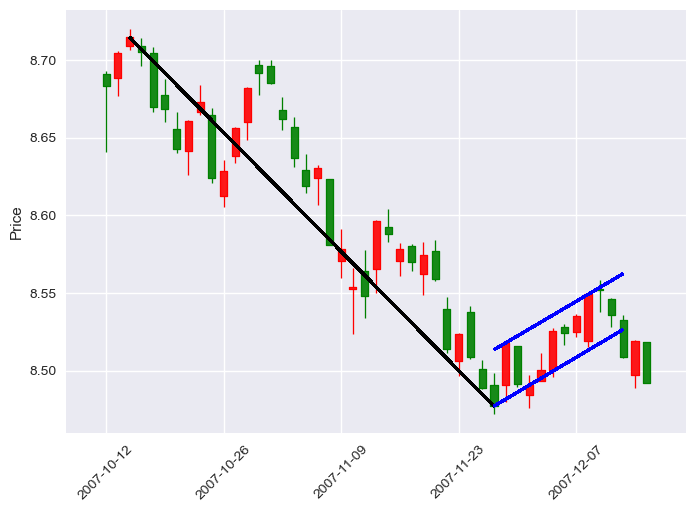

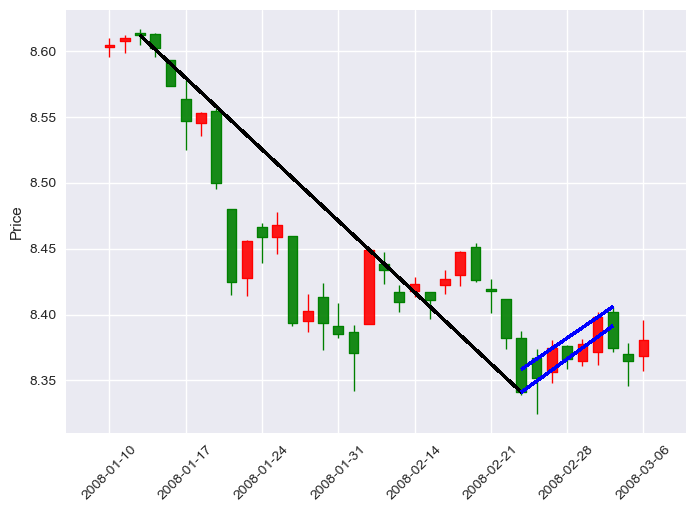

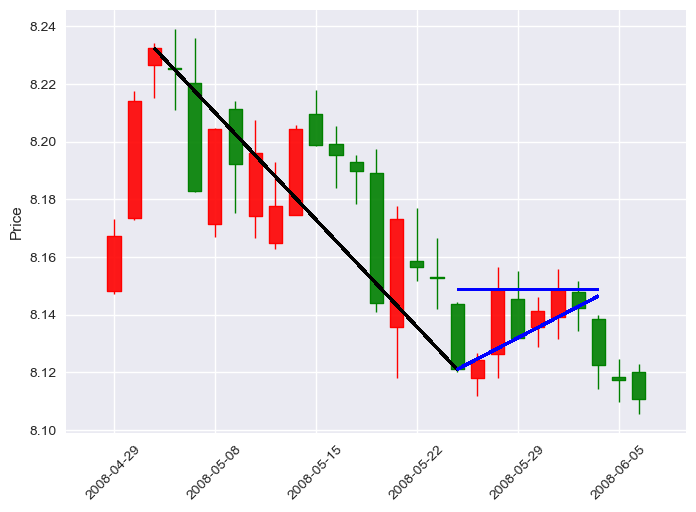

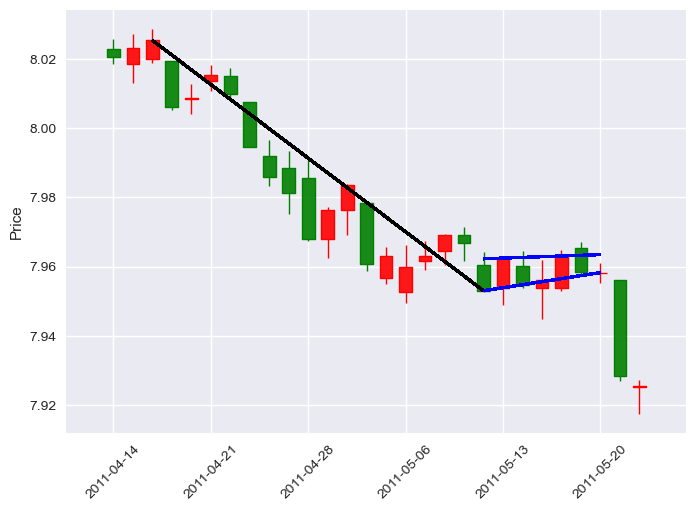

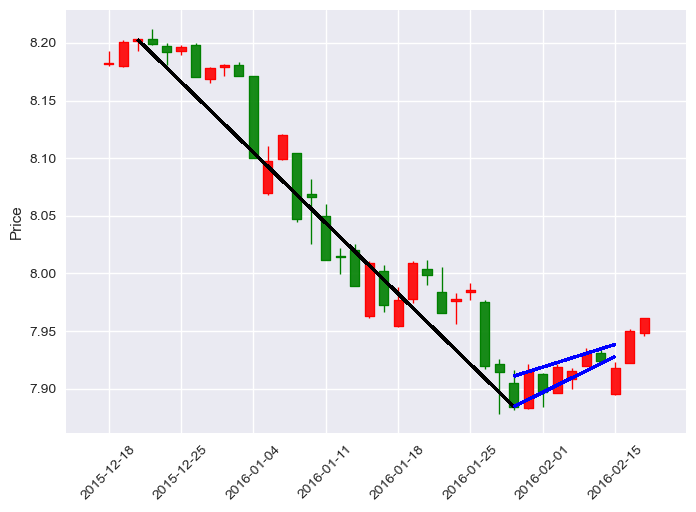

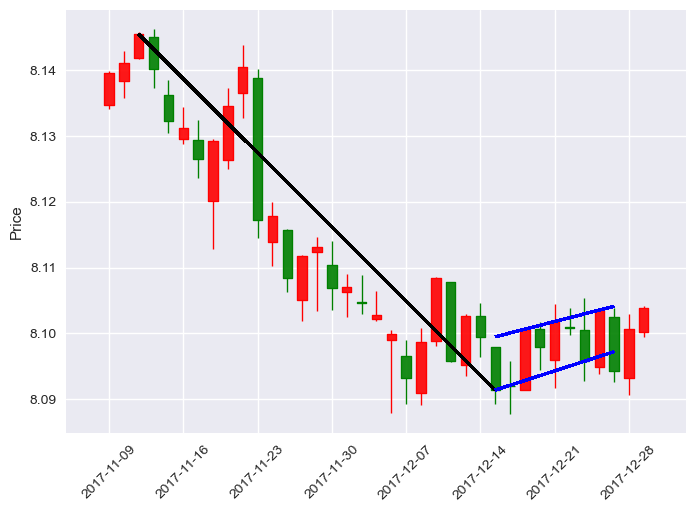

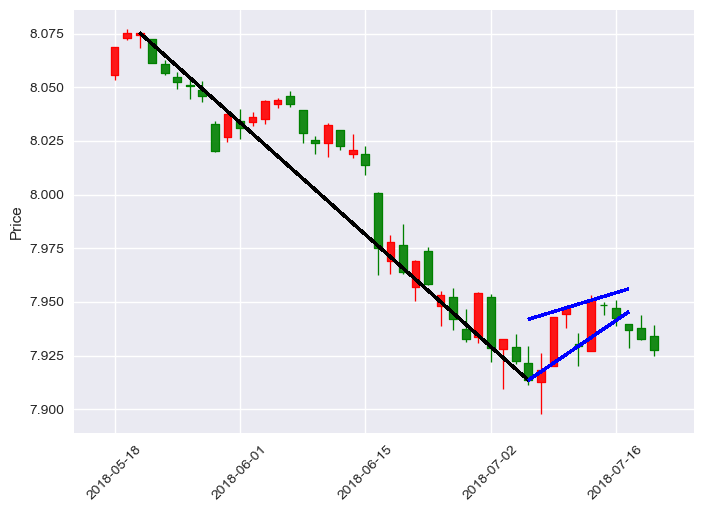

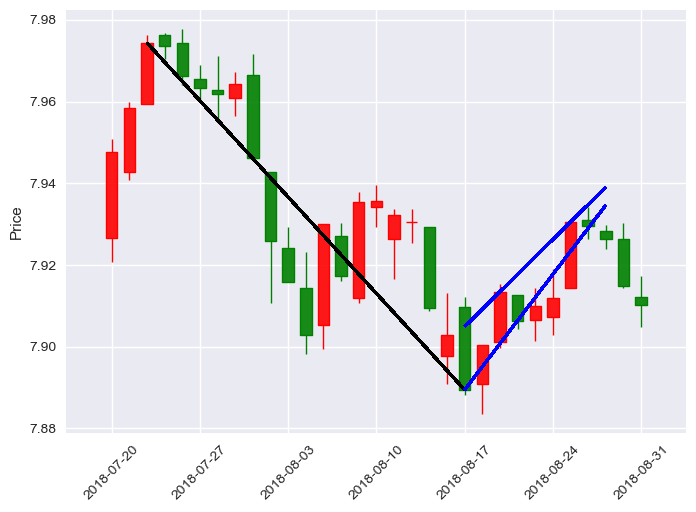

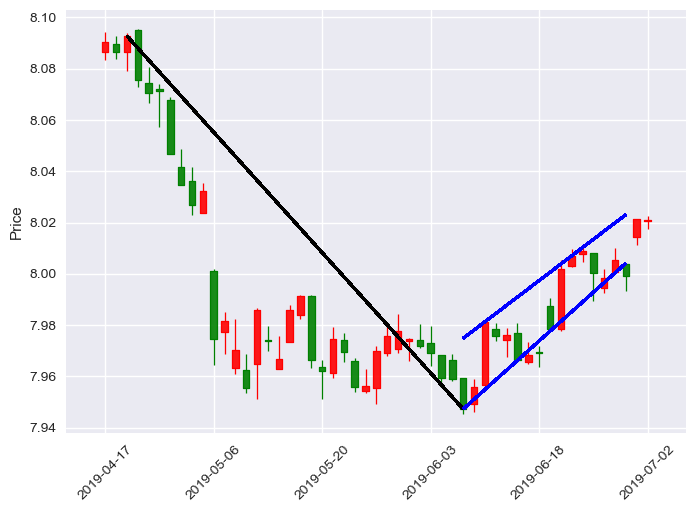

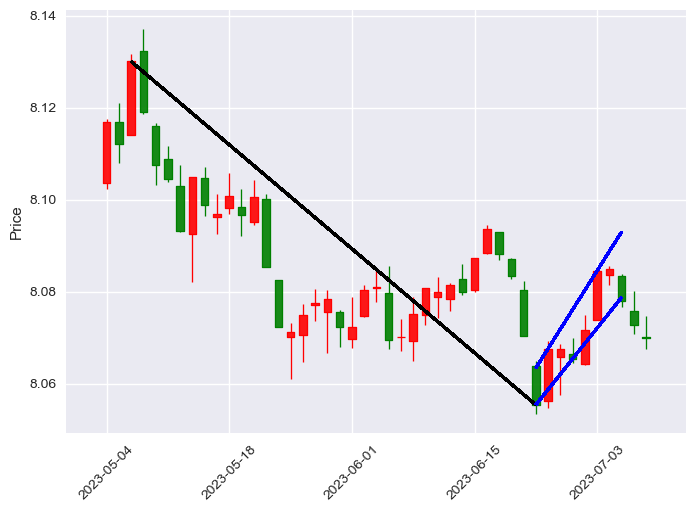

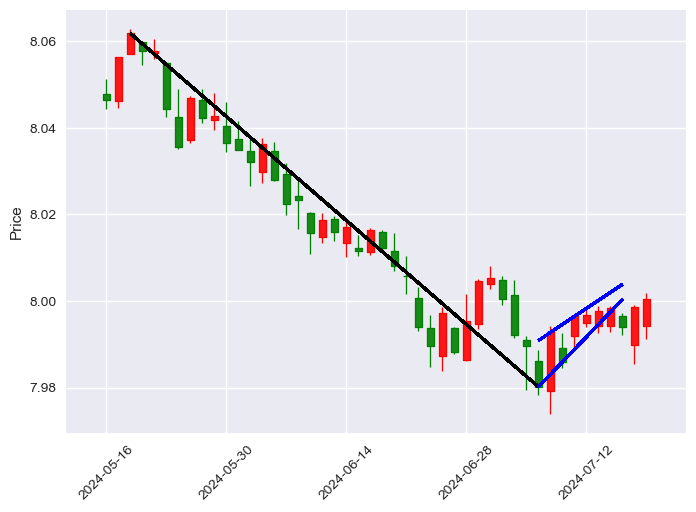


=== 牛市三角旗形态统计 ===
共发现牛市三角旗数量: 6


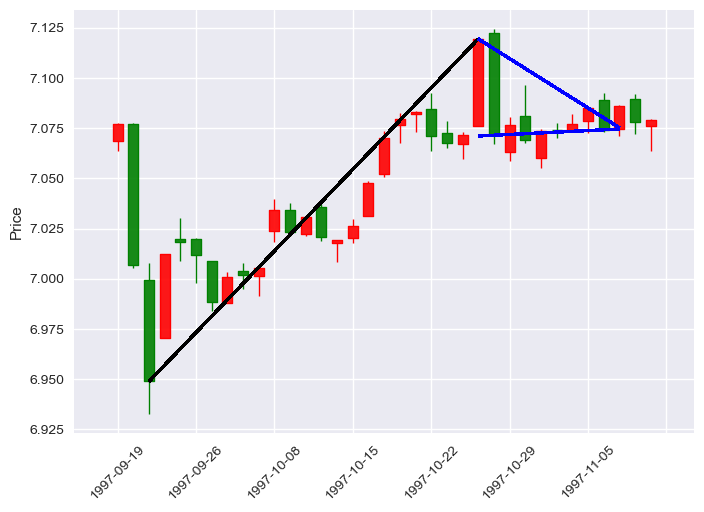

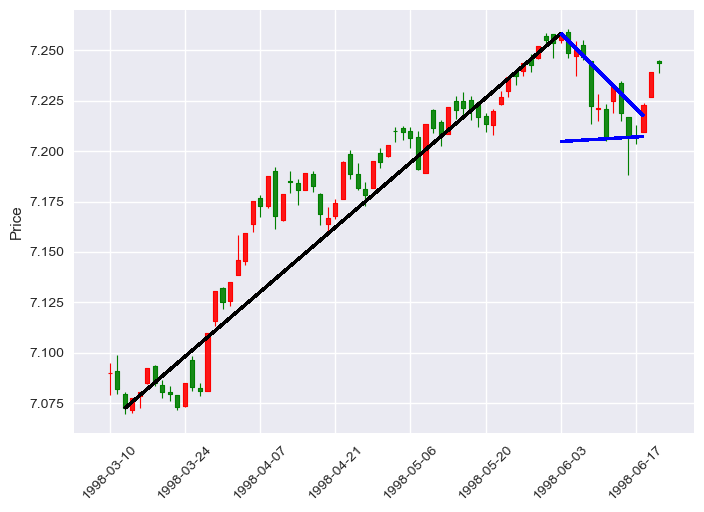

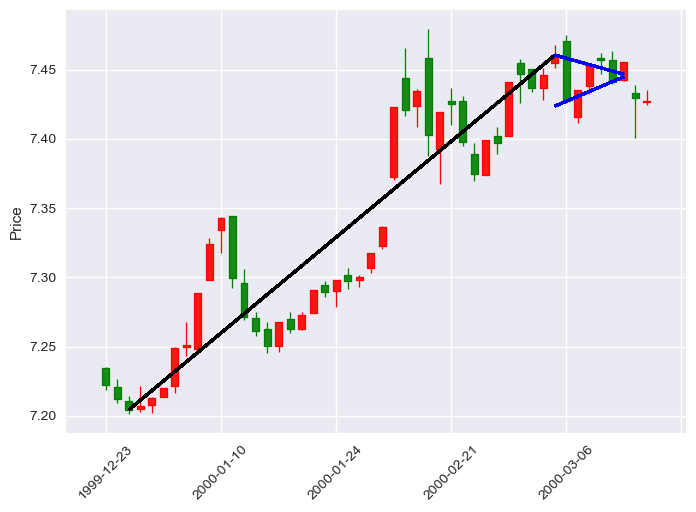

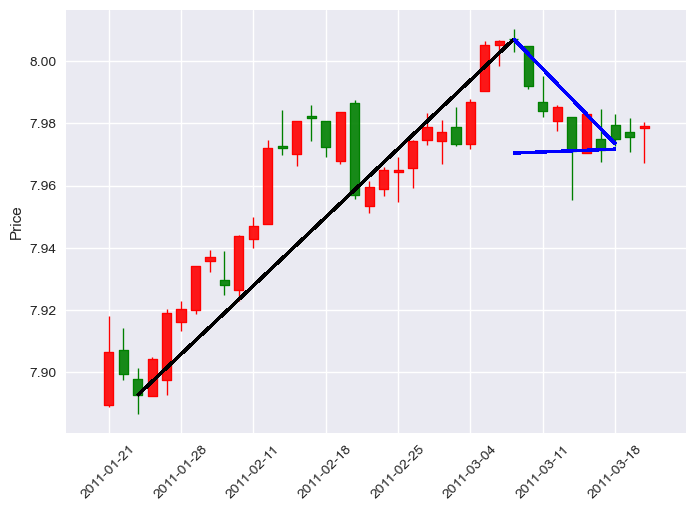

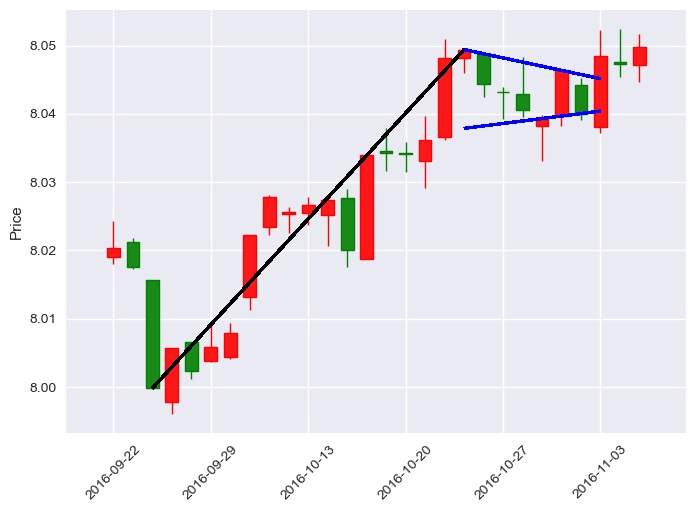

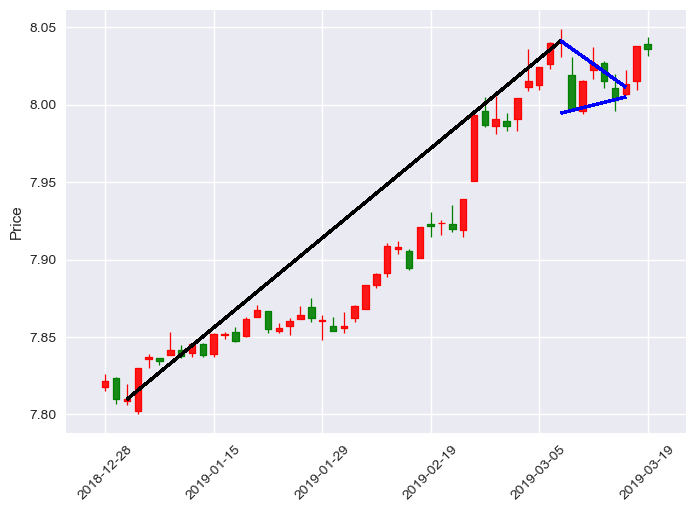


=== 熊市三角旗形态统计 ===
共发现熊市三角旗数量: 6


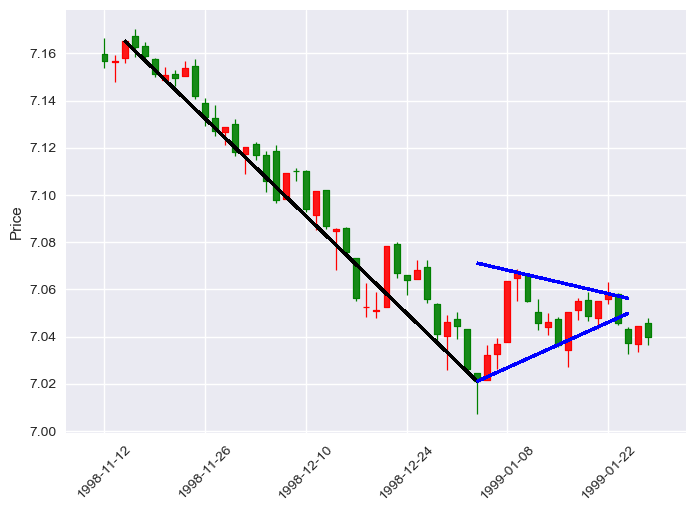

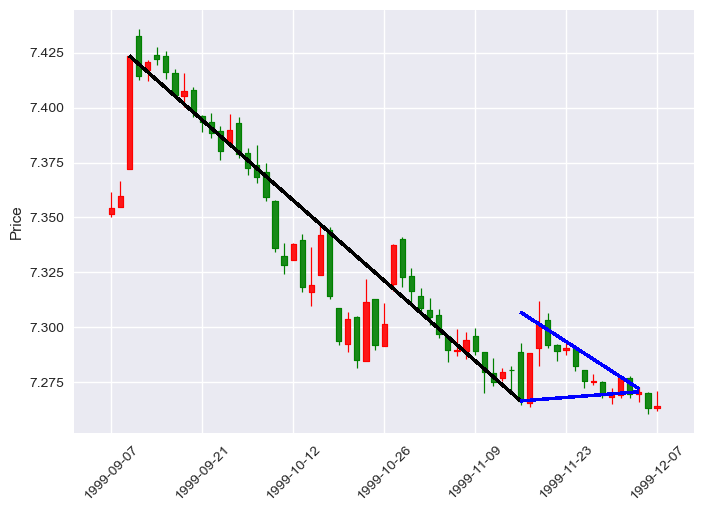

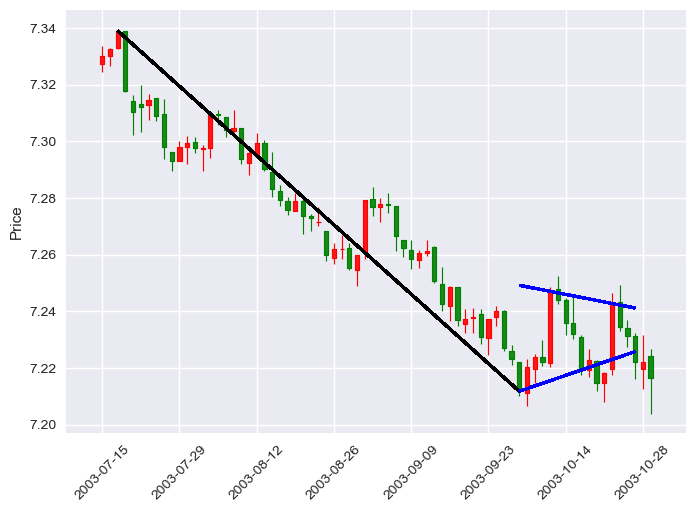

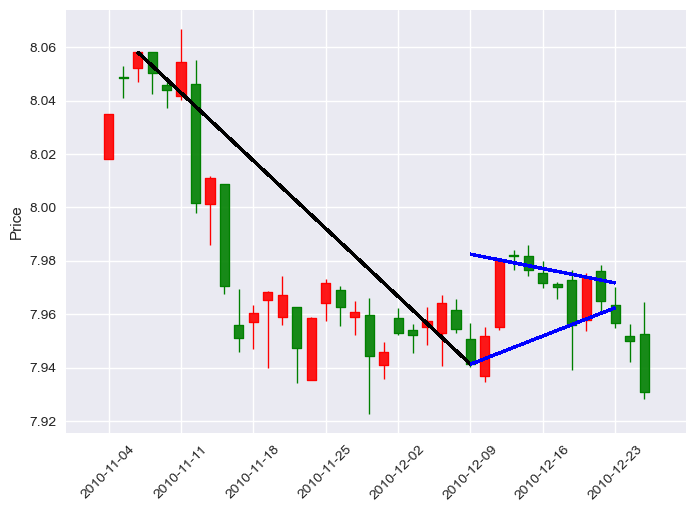

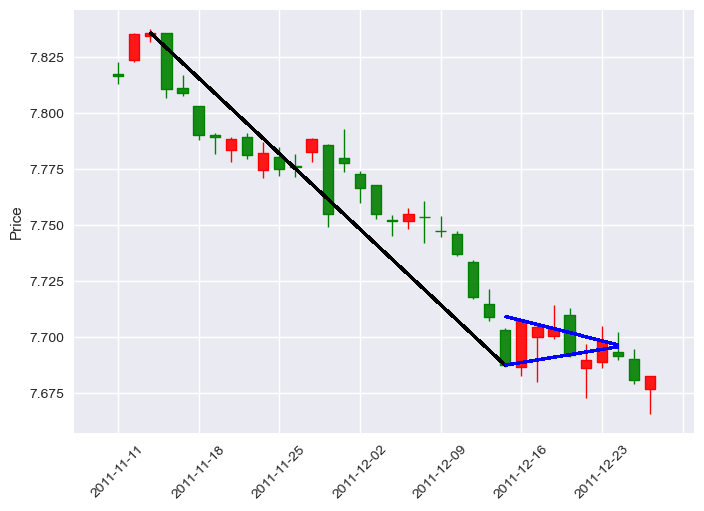

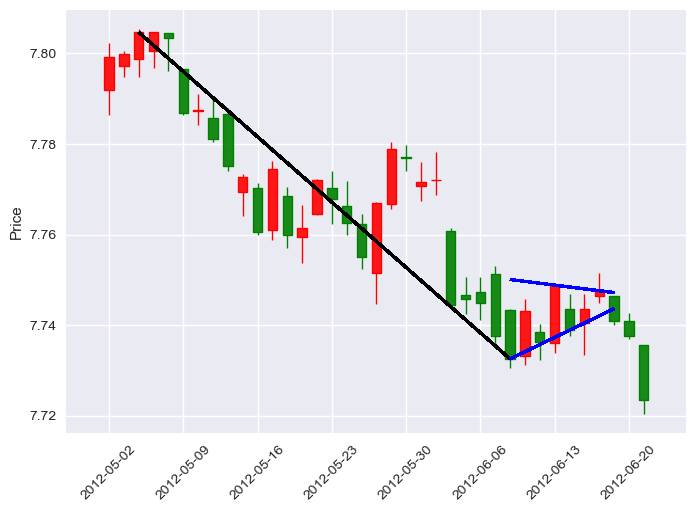

In [100]:
# 主程序（当直接运行此文件时执行）
if __name__ == '__main__':
    # 加载数据
  
    # 对价格取对数
    # 对除Change列外的所有列取对数
    # 将日期索引转换为DatetimeIndex格式
    data.index = pd.to_datetime(data.index).copy()
    
    # 对价格数据取对数
    data.loc[:, data.columns != 'Change'] = np.log(data.loc[:, data.columns != 'Change']).copy()

    # 提取收盘价数据
    dat_slice = data['Close'].to_numpy().copy()
    # 识别旗形和三角旗
    bull_flags, bear_flags, bull_pennants, bear_pennants = find_flags_pennants_pips(dat_slice, 12)  # 使用PIP点方法
    #bull_flags, bear_flags, bull_pennants, bear_pennants = find_flags_pennants_trendline(dat_slice, 10)  # 使用趋势线方法

    # 创建数据框来存储形态属性
    bull_flag_df = pd.DataFrame()
    bull_pennant_df = pd.DataFrame()
    bear_flag_df = pd.DataFrame()
    bear_pennant_df = pd.DataFrame()

    # 将形态数据组织到数据框中
    hold_mult = 1.0  # 持有期乘数（持有时间 = 旗帜宽度 * 乘数）
    
            # 打印牛市旗形形态统计信息
    print("\n=== 牛市旗形形态统计 ===")
    print(f"共发现牛市旗形数量: {len(bull_flags)}")
    # 处理牛市旗形
    for i, flag in enumerate(bull_flags):
        # 记录形态属性
        bull_flag_df.loc[i, 'flag_width'] = flag.flag_width
        bull_flag_df.loc[i, 'flag_height'] = flag.flag_height
        bull_flag_df.loc[i, 'pole_width'] = flag.pole_width
        bull_flag_df.loc[i, 'pole_height'] = flag.pole_height
        bull_flag_df.loc[i, 'slope'] = flag.resist_slope

        # 计算持有期收益
        hp = int(flag.flag_width * hold_mult)
        if flag.conf_x + hp >= len(data):
            bull_flag_df.loc[i, 'return'] = np.nan
        else:
            ret = dat_slice[flag.conf_x + hp] - dat_slice[flag.conf_x]
            bull_flag_df.loc[i, 'return'] = ret

        # 绘制牛市旗形
        plot_flag(data, flag)


    # if len(bull_flags) > 0:
    #     print("\n旗形特征统计:")
    #     print(f"旗形宽度均值: {bull_flag_df['flag_width'].mean():.2f}")
    #     print(f"旗形高度均值: {bull_flag_df['flag_height'].mean():.2f}")
    #     print(f"旗杆宽度均值: {bull_flag_df['pole_width'].mean():.2f}")
    #     print(f"旗杆高度均值: {bull_flag_df['pole_height'].mean():.2f}")
    #     print(f"旗形斜率均值: {bull_flag_df['slope'].mean():.4f}")
    #     print(f"\n持有期收益均值: {bull_flag_df['return'].mean():.4f}")
    #     print(f"持有期收益标准差: {bull_flag_df['return'].std():.4f}")

  

    # 处理熊市旗形

    # 打印熊市旗形形态统计信息
    print("\n=== 熊市旗形形态统计 ===")
    print(f"共发现熊市旗形数量: {len(bear_flags)}")

    for i, flag in enumerate(bear_flags):
        # 记录形态属性
        bear_flag_df.loc[i, 'flag_width'] = flag.flag_width
        bear_flag_df.loc[i, 'flag_height'] = flag.flag_height
        bear_flag_df.loc[i, 'pole_width'] = flag.pole_width
        bear_flag_df.loc[i, 'pole_height'] = flag.pole_height
        bear_flag_df.loc[i, 'slope'] = flag.support_slope

        # 计算持有期收益（注意熊市形态是做空，所以收益取负）
        hp = int(flag.flag_width * hold_mult)
        if flag.conf_x + hp >= len(data):
            bear_flag_df.loc[i, 'return'] = np.nan
        else:
            ret = -1 * (dat_slice[flag.conf_x + hp] - dat_slice[flag.conf_x])
            bear_flag_df.loc[i, 'return'] = ret 

        # 绘制熊市旗形
        plot_flag(data, flag)


    # if len(bear_flags) > 0:
    #     print("\n旗形特征统计:")
    #     print(f"旗形宽度均值: {bear_flag_df['flag_width'].mean():.2f}")
    #     print(f"旗形高度均值: {bear_flag_df['flag_height'].mean():.2f}")
    #     print(f"旗杆宽度均值: {bear_flag_df['pole_width'].mean():.2f}")
    #     print(f"旗杆高度均值: {bear_flag_df['pole_height'].mean():.2f}")
    #     print(f"旗形斜率均值: {bear_flag_df['slope'].mean():.4f}")
    #     print(f"\n持有期收益均值: {bear_flag_df['return'].mean():.4f}")
    #     print(f"持有期收益标准差: {bear_flag_df['return'].std():.4f}")

                 # 打印牛市三角旗形态统计信息
    print("\n=== 牛市三角旗形态统计 ===")
    print(f"共发现牛市三角旗数量: {len(bull_pennants)}")
    # 处理牛市三角旗
    for i, pennant in enumerate(bull_pennants):
        # 记录形态属性
        bull_pennant_df.loc[i, 'pennant_width'] = pennant.flag_width
        bull_pennant_df.loc[i, 'pennant_height'] = pennant.flag_height
        bull_pennant_df.loc[i, 'pole_width'] = pennant.pole_width
        bull_pennant_df.loc[i, 'pole_height'] = pennant.pole_height

        # 计算持有期收益
        hp = int(pennant.flag_width * hold_mult)
        if pennant.conf_x + hp >= len(data):
            bull_pennant_df.loc[i, 'return'] = np.nan
        else:
            ret = dat_slice[pennant.conf_x + hp] - dat_slice[pennant.conf_x]
            bull_pennant_df.loc[i, 'return'] = ret 

        # 绘制牛市三角旗
        plot_flag(data, pennant)


    # if len(bull_pennants) > 0:
    #     print("\n三角旗特征统计:")
    #     print(f"三角旗宽度均值: {bull_pennant_df['pennant_width'].mean():.2f}")
    #     print(f"三角旗高度均值: {bull_pennant_df['pennant_height'].mean():.2f}")
    #     print(f"旗杆宽度均值: {bull_pennant_df['pole_width'].mean():.2f}")
    #     print(f"旗杆高度均值: {bull_pennant_df['pole_height'].mean():.2f}")
    #     print(f"\n持有期收益均值: {bull_pennant_df['return'].mean():.4f}")
    #     print(f"持有期收益标准差: {bull_pennant_df['return'].std():.4f}")


                         # 打印熊市三角旗形态统计信息
    print("\n=== 熊市三角旗形态统计 ===")
    print(f"共发现熊市三角旗数量: {len(bear_pennants)}")
    # 处理熊市三角旗
    for i, pennant in enumerate(bear_pennants):
        # 记录形态属性
        bear_pennant_df.loc[i, 'pennant_width'] = pennant.flag_width
        bear_pennant_df.loc[i, 'pennant_height'] = pennant.flag_height
        bear_pennant_df.loc[i, 'pole_width'] = pennant.pole_width
        bear_pennant_df.loc[i, 'pole_height'] = pennant.pole_height

        # 计算持有期收益（注意熊市形态是做空，所以收益取负）
        hp = int(pennant.flag_width * hold_mult)
        if pennant.conf_x + hp >= len(data):
            bear_pennant_df.loc[i, 'return'] = np.nan
        else:
            ret = -1 * (dat_slice[pennant.conf_x + hp] - dat_slice[pennant.conf_x])
            bear_pennant_df.loc[i, 'return'] = ret 

        # 绘制熊市三角旗
        plot_flag(data, pennant)


    # if len(bear_pennants) > 0:
    #     print("\n三角旗特征统计:")
    #     print(f"三角旗宽度均值: {bear_pennant_df['pennant_width'].mean():.2f}")
    #     print(f"三角旗高度均值: {bear_pennant_df['pennant_height'].mean():.2f}")
    #     print(f"旗杆宽度均值: {bear_pennant_df['pole_width'].mean():.2f}")
    #     print(f"旗杆高度均值: {bear_pennant_df['pole_height'].mean():.2f}")
    #     print(f"\n持有期收益均值: {bear_pennant_df['return'].mean():.4f}")
    #     print(f"持有期收益标准差: {bear_pennant_df['return'].std():.4f}")


<font color=steel size=5 face=雅黑>3.将旗形绘制到同一坐标系下</font>

<font color=steel size=5 face=雅黑>3.将旗形绘制到同一坐标系下（只用收盘价）</font>